# Lab 4: Working with 'real' data



In [4]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

In [4]:
hf = h5py.File('gammaray_lab4.h5', 'r') #Import the file

In [5]:
hf.keys() # Look at the header

<KeysViewHDF5 ['data']>

In [6]:
# data = np.array(hf.get('data')) # import the data into an array variable using the get method

In [7]:
hf.close() # Close the file

## Problem 1

*Create a feew plot generally exploring your data*

In [5]:
hf = h5py.File('gammaray_lab4.h5', 'r') #Import the file
data = np.array(hf.get('data'))
hf.close

<bound method File.close of <HDF5 file "gammaray_lab4.h5" (mode r)>>

In [6]:
def makePlot(x, y, start, end, step = 1):
    
    plt.plot(x[int(start):int(end):int(step)], y[int(start):int(end):int(step)])
    plt.tick_params(labelsize = 24)

In [7]:
time = data[0,:]
solarPhase = data[1,:]
long = data[2,:]
counts = data[3,:]

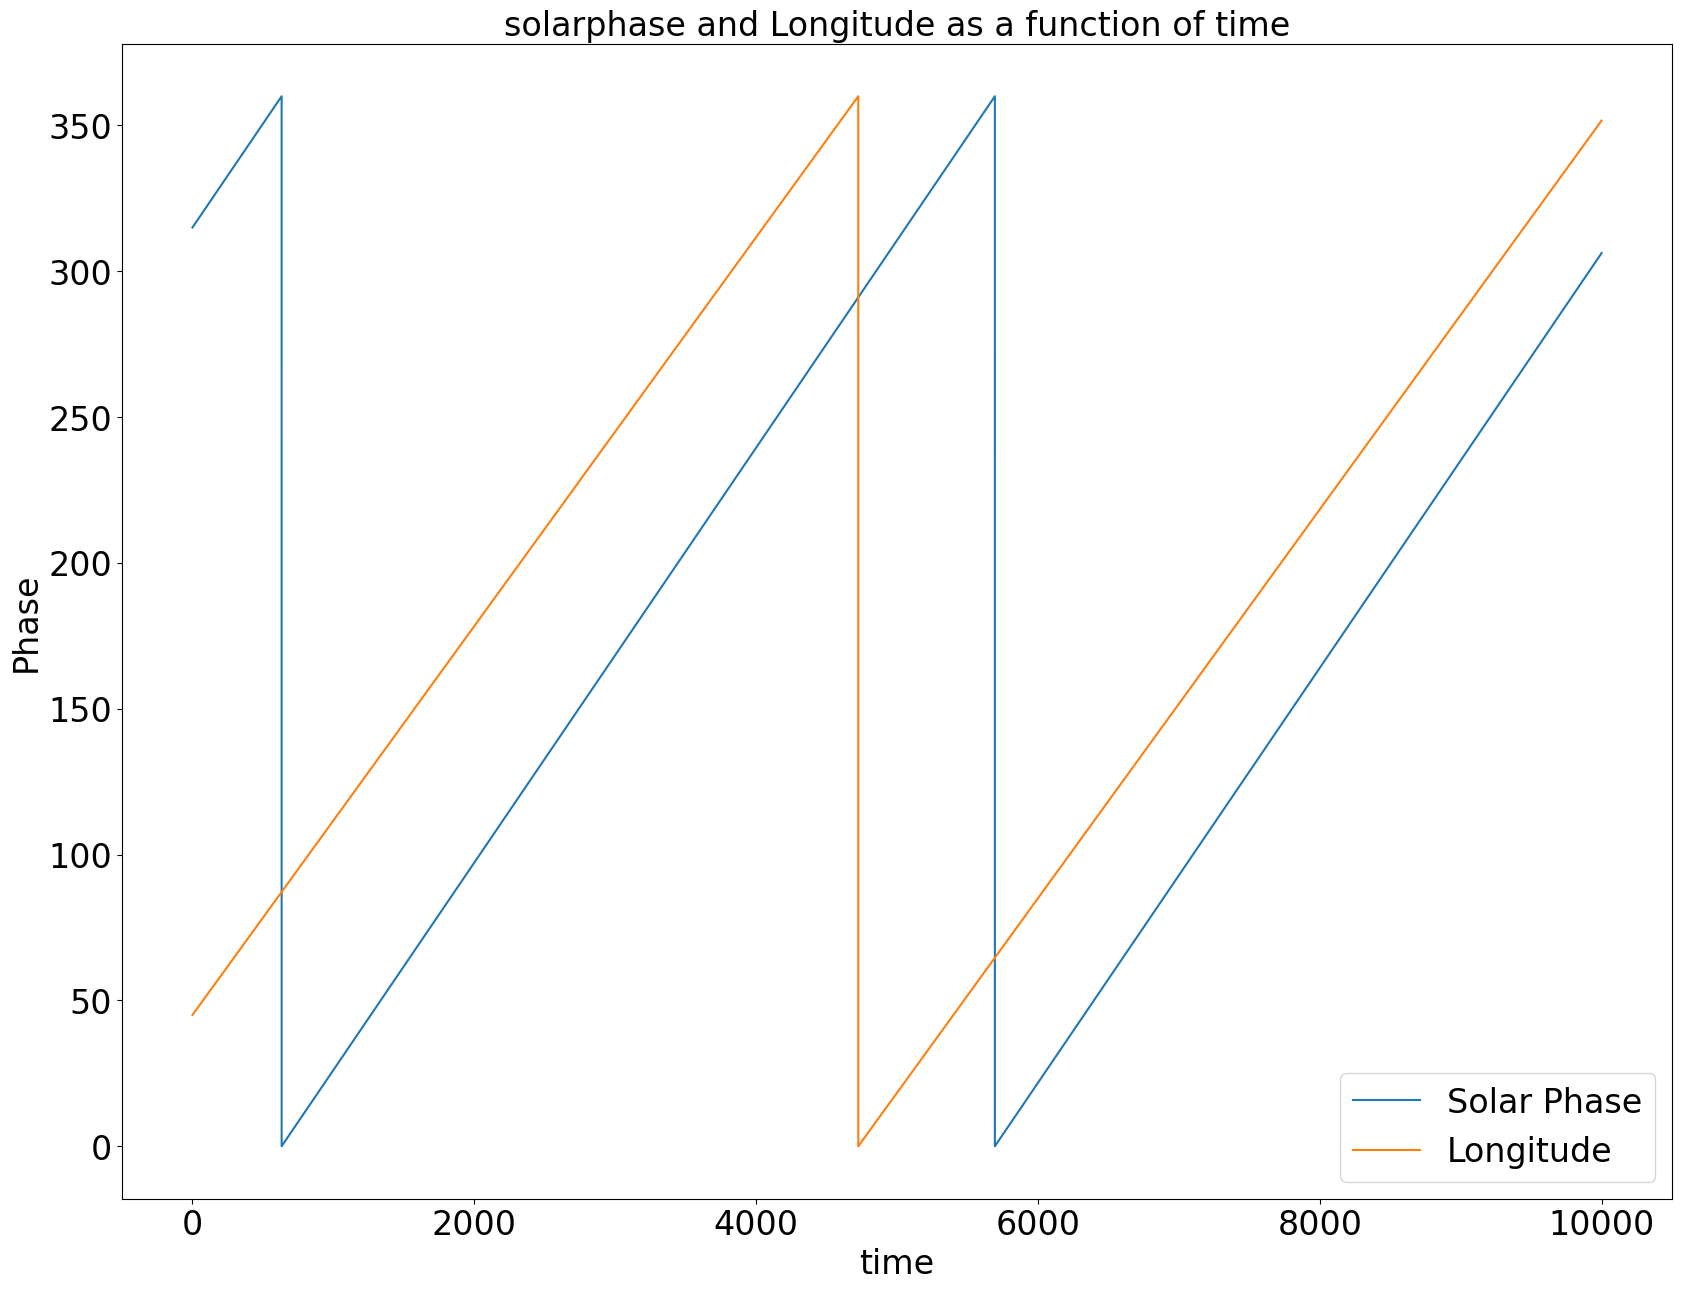

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (20, 15))
ax.tick_params(labelsize = 24)

time = time - time[0]

ax.plot(time[0:int(1e5)], solarPhase[0:int(1e5)], label = 'Solar Phase')
ax.plot(time[0:int(1e5)], long[0:int(1e5)], label = 'Longitude')

plt.xlabel("time", fontsize = 24)
plt.ylabel("Phase", fontsize = 24)
plt.title("solarphase and Longitude as a function of time", fontsize = 24);
ax.legend(fontsize = 24)

The above plot shows the solar phase and the longitude as a function of time for a small subset of the data. From the above it is obvius that both of these are linear and periodic as expected of a earth orbiting satellite. 

(-5.0, 35.0)

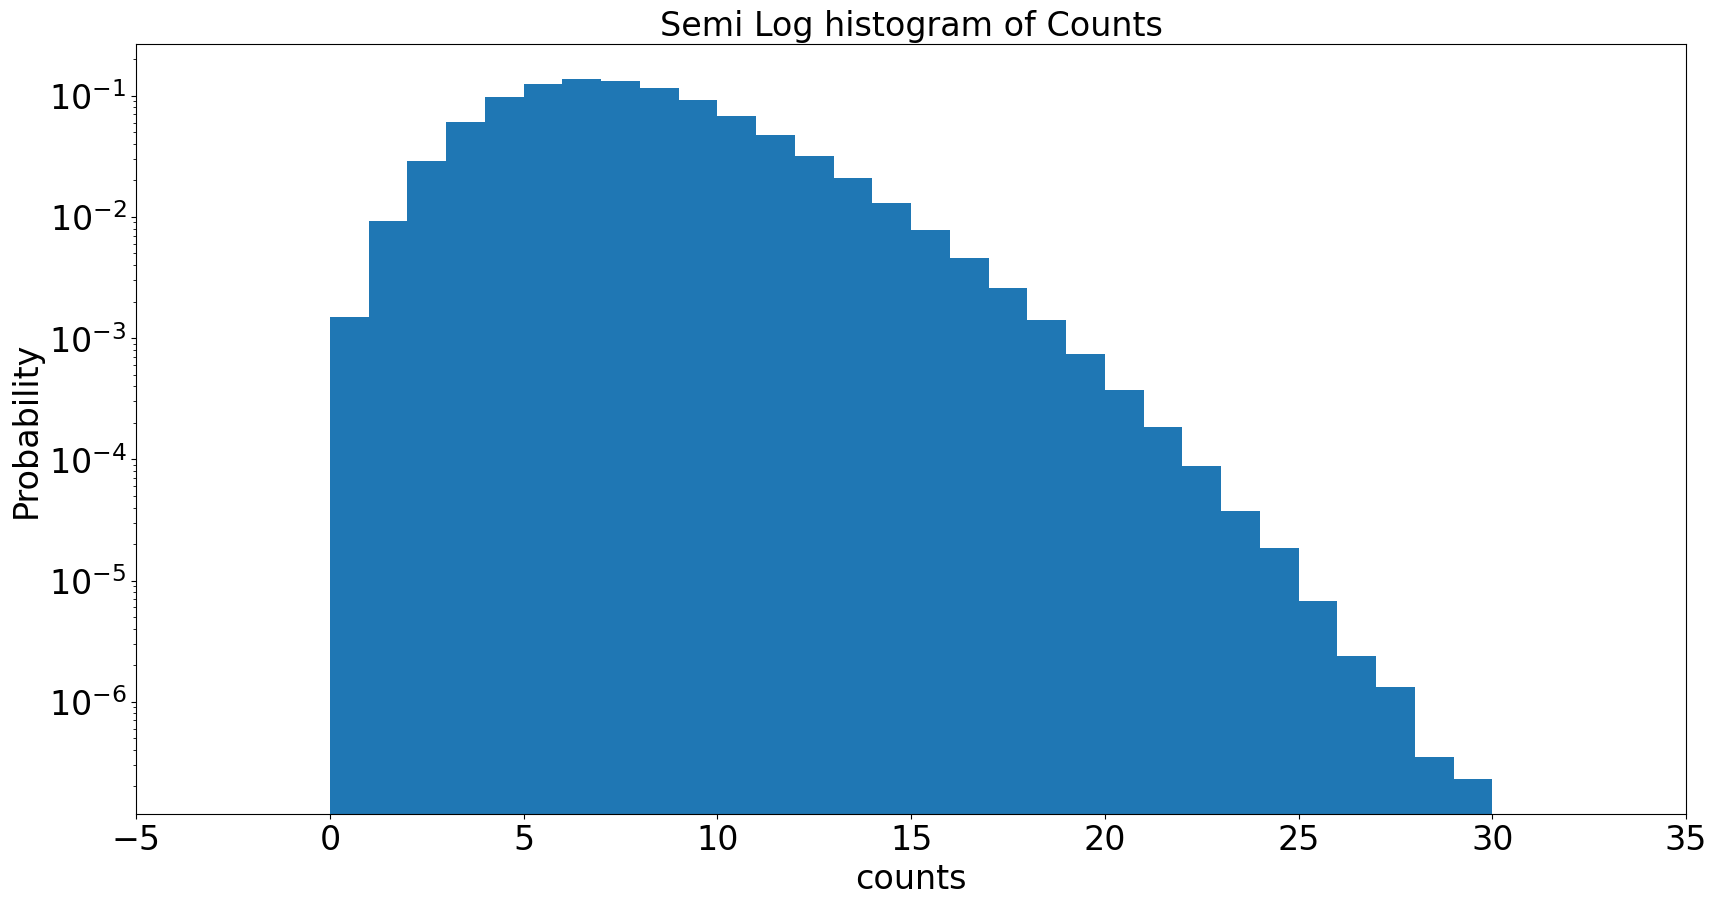

In [32]:
fig, ax = plt.subplots(1,1, figsize = (20,10))


ax.set_yscale('log')
ax.hist(counts, bins = 30,density = True)
ax.tick_params(labelsize = 24)
ax.set_title('Semi Log histogram of Counts', fontsize = 24)
ax.set_ylabel('Probability', fontsize = 24)
ax.set_xlabel('counts', fontsize = 24)
ax.set_xlim([-5, 35])

This plot is to demonstrate the presence of signal contamination. There is no evidence of an exceptionally long tail or any outlying point in in this distribution. 

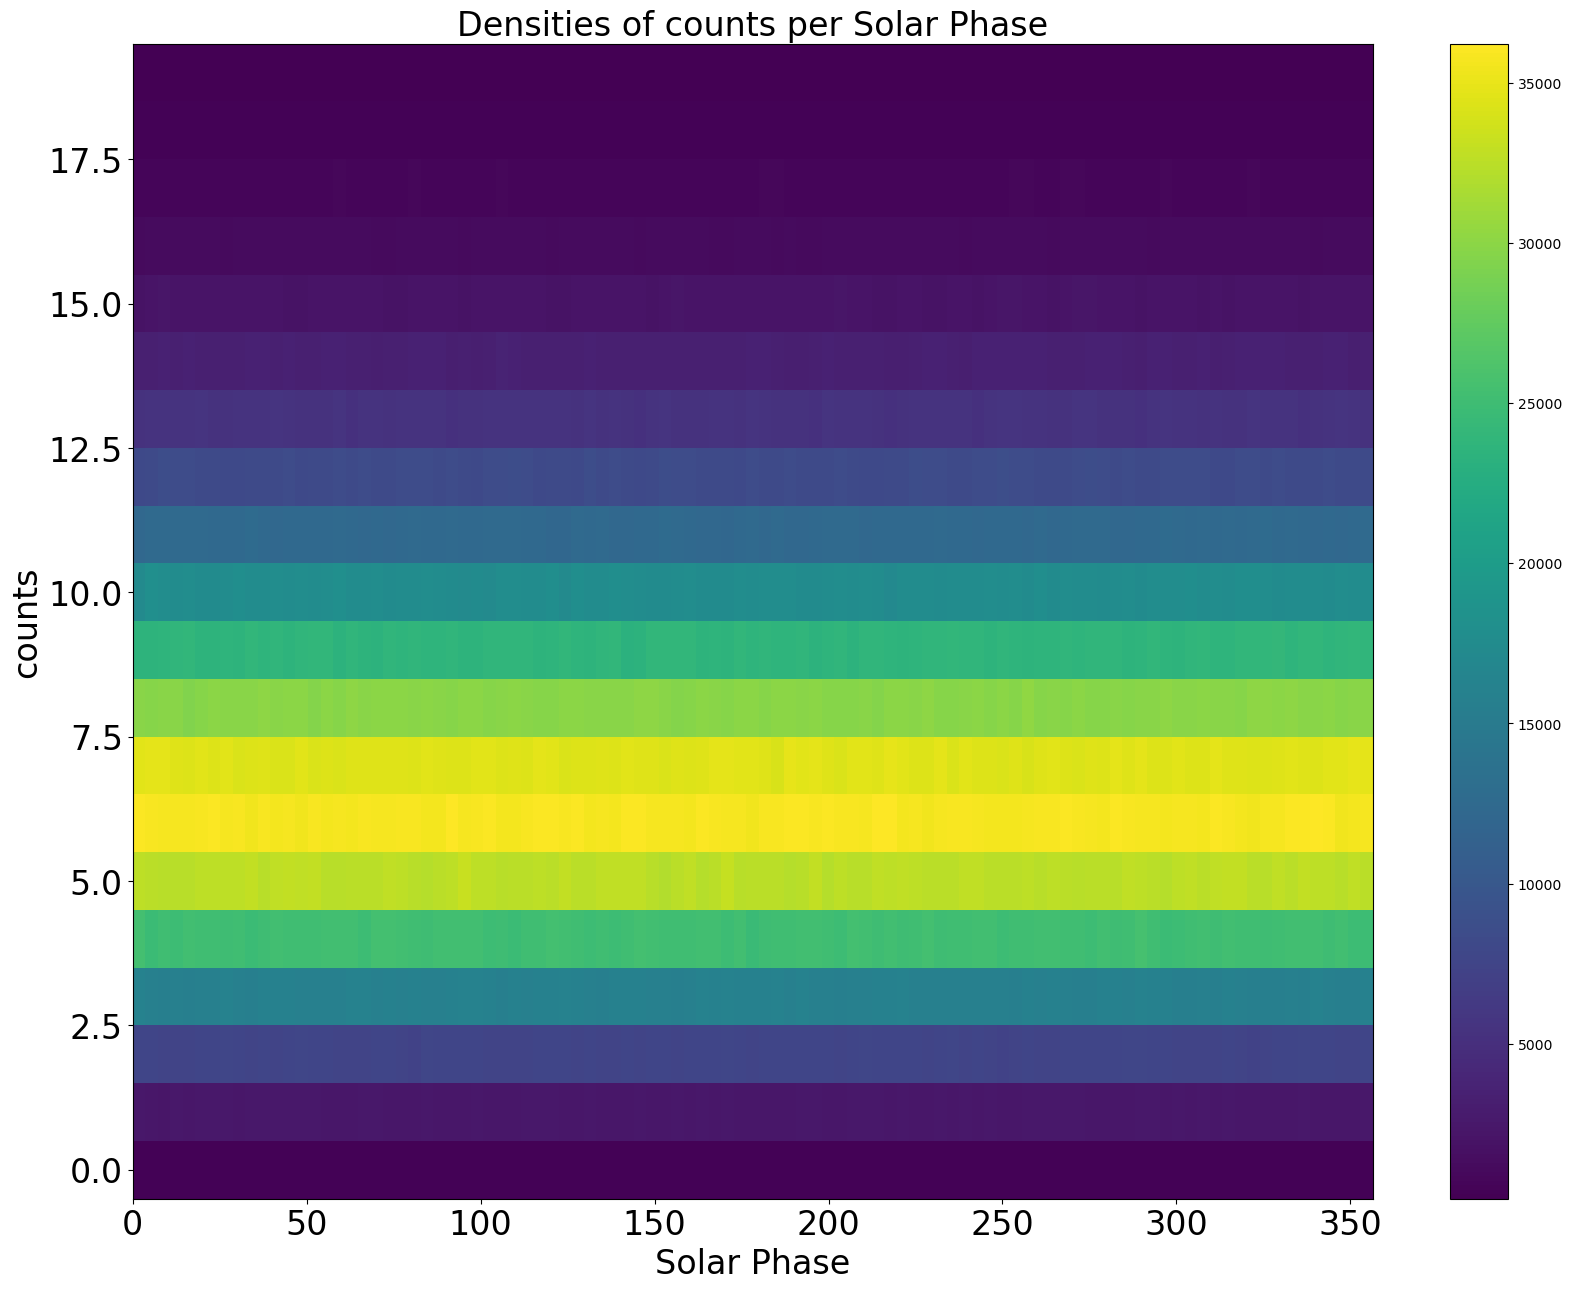

In [20]:

xedges = np.arange(0,360,3.6)
yedges = np.arange(-0.5,20.5)
plt.tick_params(labelsize = 24)
plt.hist2d(solarPhase[0:-1], counts[0:-1], [xedges, yedges])
plt.colorbar()
plt.xlabel("Solar Phase", fontsize = 24)
plt.ylabel("counts", fontsize = 24)
plt.title("Densities of counts per Solar Phase", fontsize = 24);

This plot is the count density with respect to the solar phase. It being constant is evidence that there is no dependence of the counts with respect to solar phase. That said the data is distributed around some average in this plot and because the counts from a gamma ray detector are discreet we expect that the distribution for many measurements should follow a poisson distribution. 

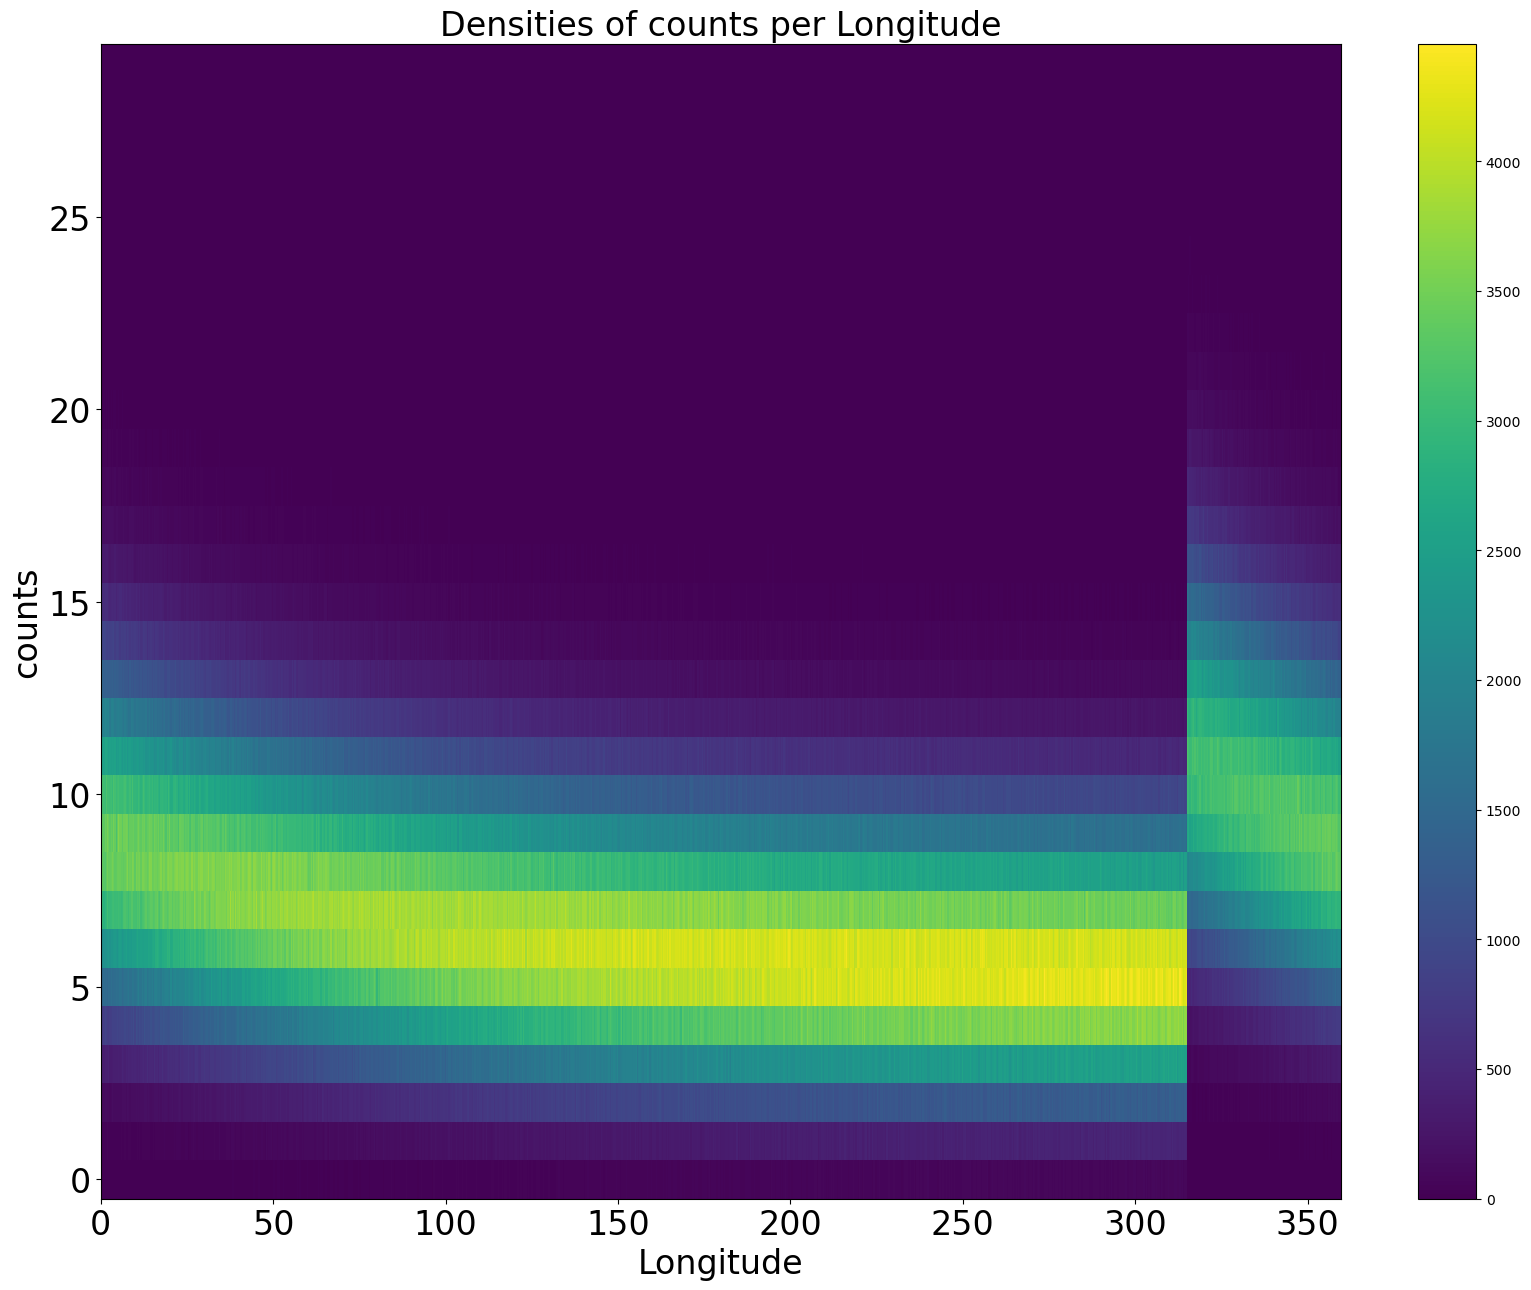

In [21]:
xedges = np.arange(0,360,0.36)
yedges = np.arange(-0.5,30.5)

plt.hist2d(long[0:-1], counts[0:-1], [xedges, yedges])
plt.tick_params(labelsize = 24)
plt.colorbar()
plt.xlabel("Longitude", fontsize = 24)
plt.ylabel("counts", fontsize = 24)
plt.title("Densities of counts per Longitude", fontsize = 24);

This plot is the number of counts with respect to the longitude. From this plot it is clear that there is some kind of dependence on the number of counts with respect to the longitude. Again it appears that the number of counts is distributed around some mean, and that the mean is dependent on longitude. 

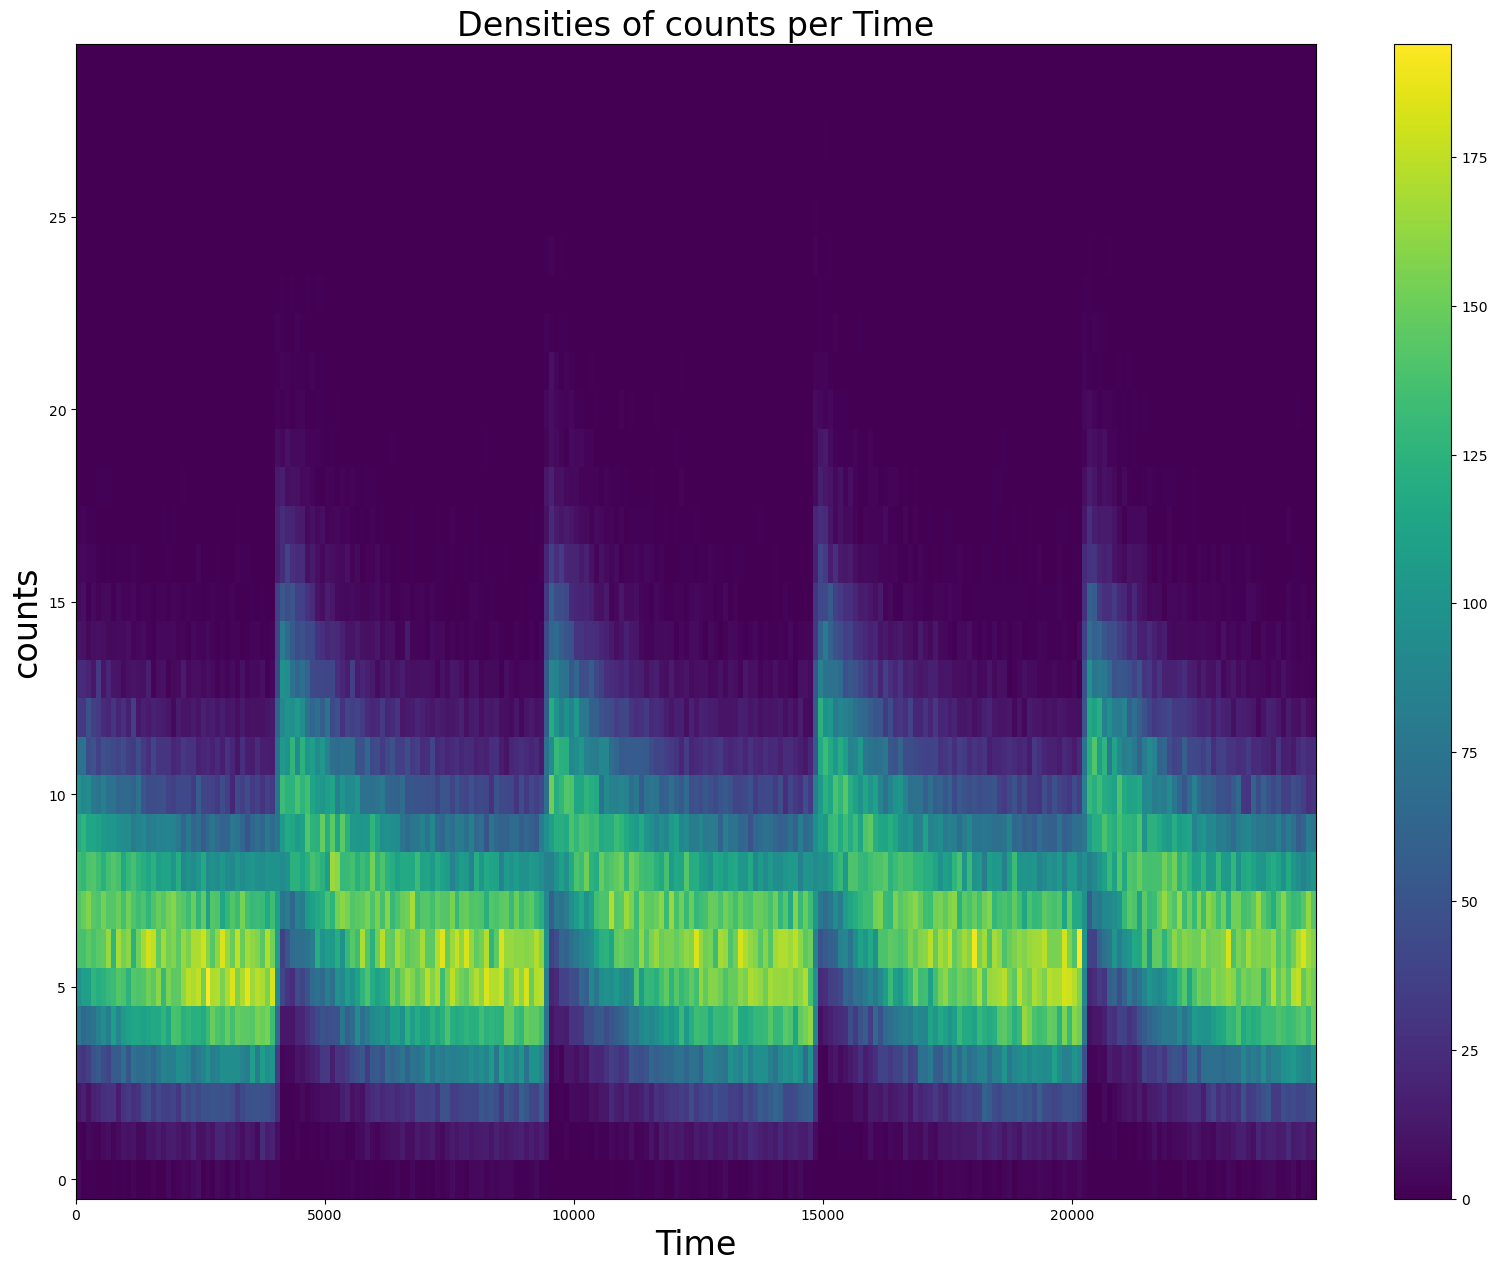

In [22]:
xedges = time[0:250000:1000]
yedges = np.arange(-0.5,30.5)

plt.hist2d(time[0:250000], counts[0:250000], [xedges, yedges])
plt.xlabel("Time", fontsize = 24)
plt.ylabel("counts", fontsize = 24)
plt.title("Densities of counts per Time", fontsize = 24);
plt.colorbar()

This graph is the counts with respect to time for some small interval of time. From this plot we see that the counts is dependent on time, which if it is dependent on longitude, is to be expected. Longitude is periodic given that the satellite is earth orbiting and it seems like the number of counts is increasing at some point each orbit and then slowly falling off until the satellite again crosses the corresponding longitude. 

The task of estimating the background now falls to estimating the mean an of the counts and its time dependence. To do this I will calculate the mean of each slice of the 2d histogram of the counts with respect to the longitude

2) *Find and describe as accurately as possible how the background changes*

The below histogram illstrates that the number of counts increases at longitude = 315 and slowly decreases over the rest of the period. At any point around the longitude the number of counts is distributed according to a poisson distribution. Overlayed on the histogram is the mean of each slice along longitude. 


In [36]:
newLong = (long + 45) % 360 # Adding 45 and modulo by 360 ensures the "reset" at 315 is now at 0

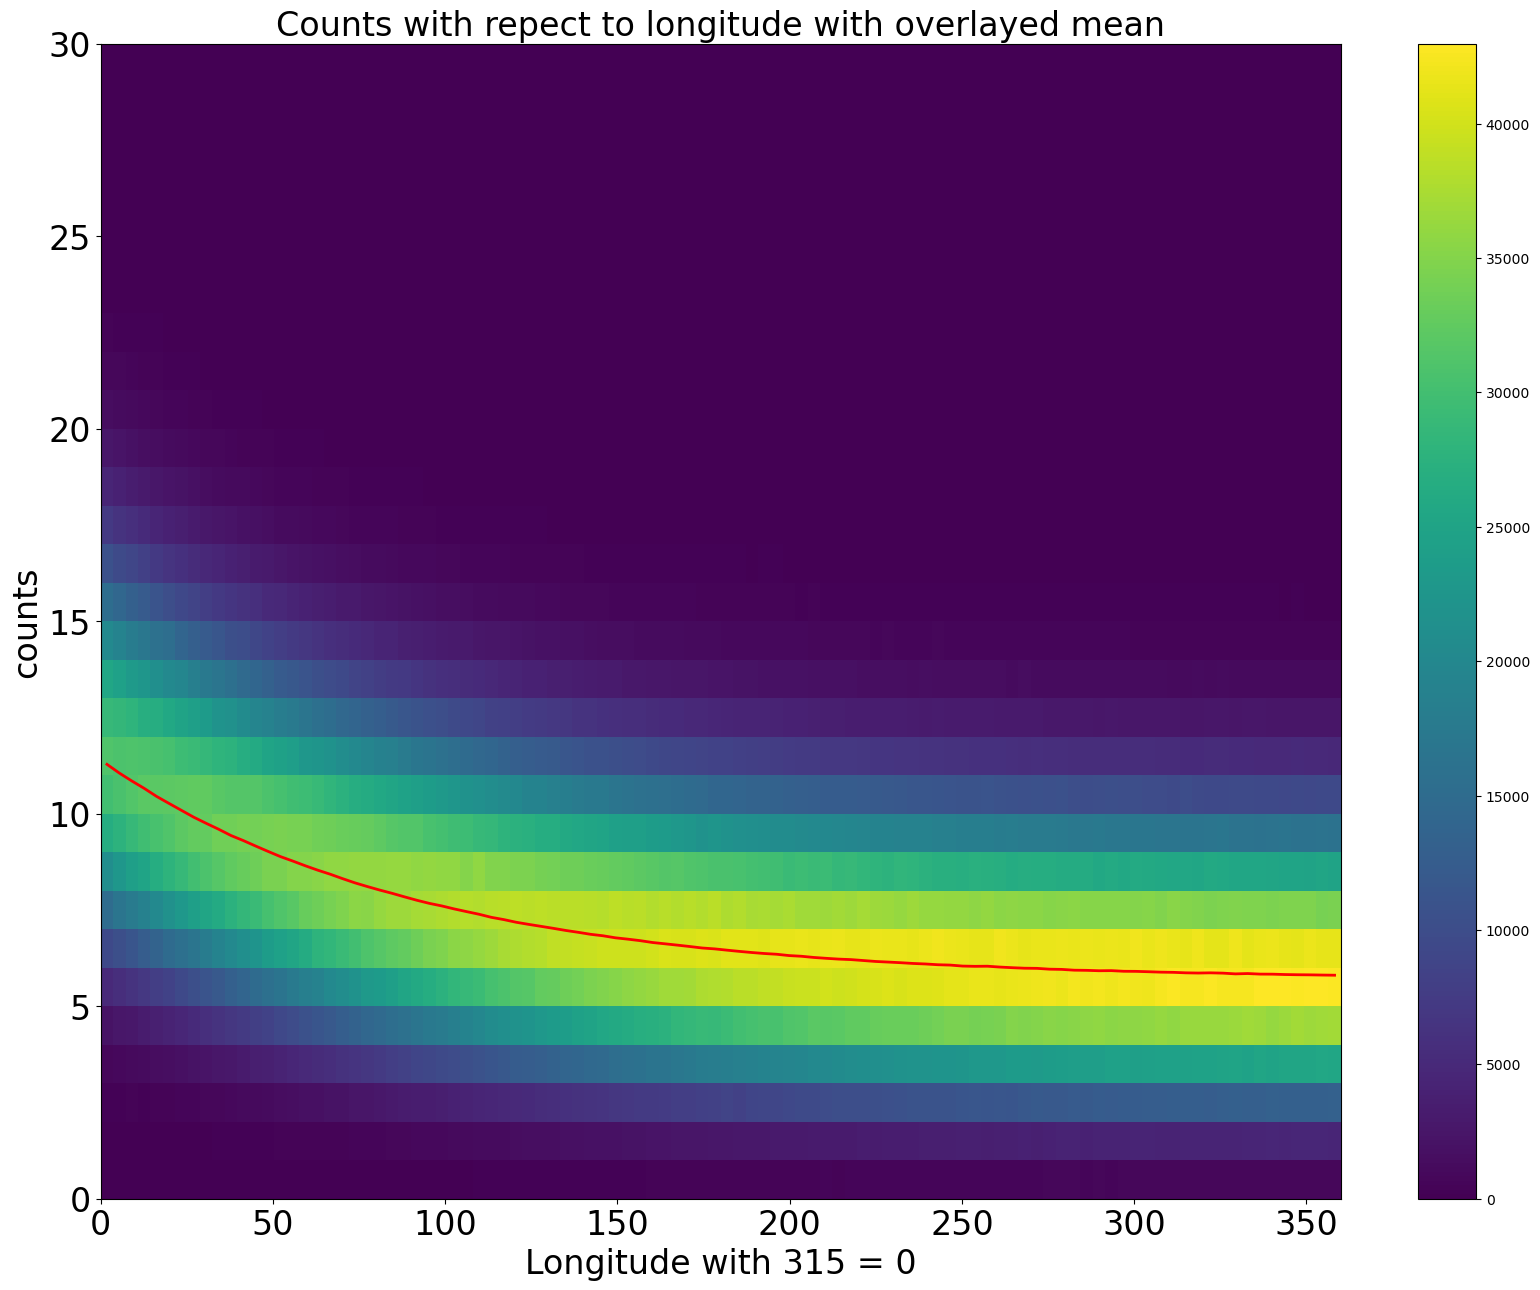

In [42]:
H, xedge, yedge, img = plt.hist2d(newLong, counts, [100,30], [[0, 360],[0,30]])

longBinCenters = (xedge[1:] + xedge[:-1]) / 2
y = yedge[:-1]

means = np.sum(np.matmul(H, np.diag(y)), axis = 1) / np.sum(H, axis = 1)
plt.plot(longBinCenters, means, color='red', linewidth=2, label="Mean")

plt.title("Counts with repect to longitude with overlayed mean", fontsize = 24)
plt.xlabel('Longitude with 315 = 0', fontsize = 24)
plt.ylabel('counts', fontsize = 24)
plt.tick_params(labelsize = 24)

plt.colorbar(img)

3) *Create a model for the background that includes time dependence, and explicitly compare your model to the data.*

In [44]:
def function(x, a, b, c):
    return a * np.exp(-b * x) + c

[a, b, c], _ = scipy.optimize.curve_fit(function, longBinCenters, means)
print("a = {}, b = {}, c = {}".format(a,b,c))

a = 5.694674463081075, b = 0.011099076974044247, c = 5.698361862102251


<ipython-input-44-0ec64563eeeb>:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


We don't care about the covariance. So we ignore that part. Also what's the difference between his exponential decay function and mine? His includes the scale on the outside while mine is on the inside? guess it technically dosn't matter. 


<ipython-input-45-a2836a274023>:6: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(img);


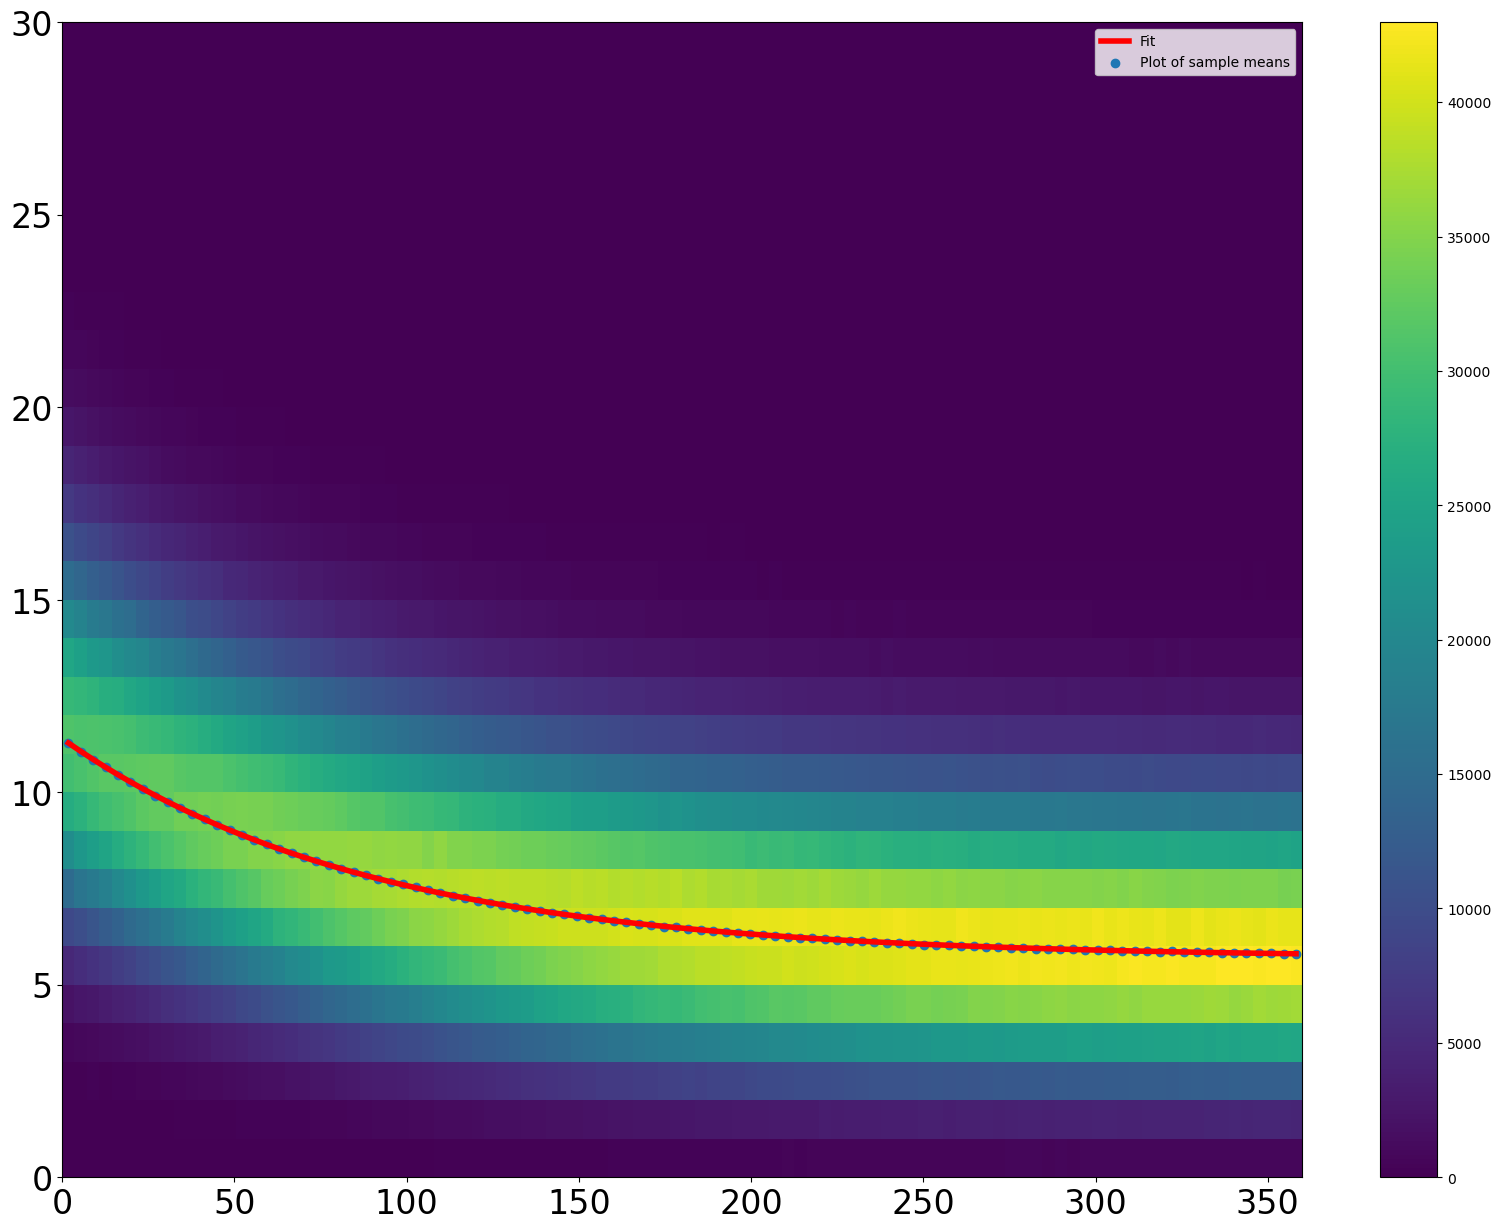

In [45]:
plt.tick_params(labelsize = 24)

plt.imshow(H.T, aspect ='auto', origin='lower',
            extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]])
plt.scatter(longBinCenters, means, linewidth = 1, label = "Plot of sample means")
plt.colorbar(img);
plt.plot(longBinCenters, function(longBinCenters, a, b, c),
          linewidth = 4, color = 'r', label = "Fit")
plt.legend()

We know that the longitude oscillates periodically. One entire orbital phase corresponds to an entire orbit, therefore setting t = 0 to the beginning of the orbit or when long = 0, and tfinal = 360 gives some way to measure the counts on the satellite as a function of time 

In [46]:
# Find get the indexes where one orbit is completed
times0 = np.where(long == 0)

#Find the time taken to complete one orbit in seconds
time[times0[0][1]]-time[times0[0][0]]

5400.0

In [47]:
def long(t):
    # the longitude as a function of time
    return (360/5400)*t

<ipython-input-48-54131fe79531>:8: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(img)


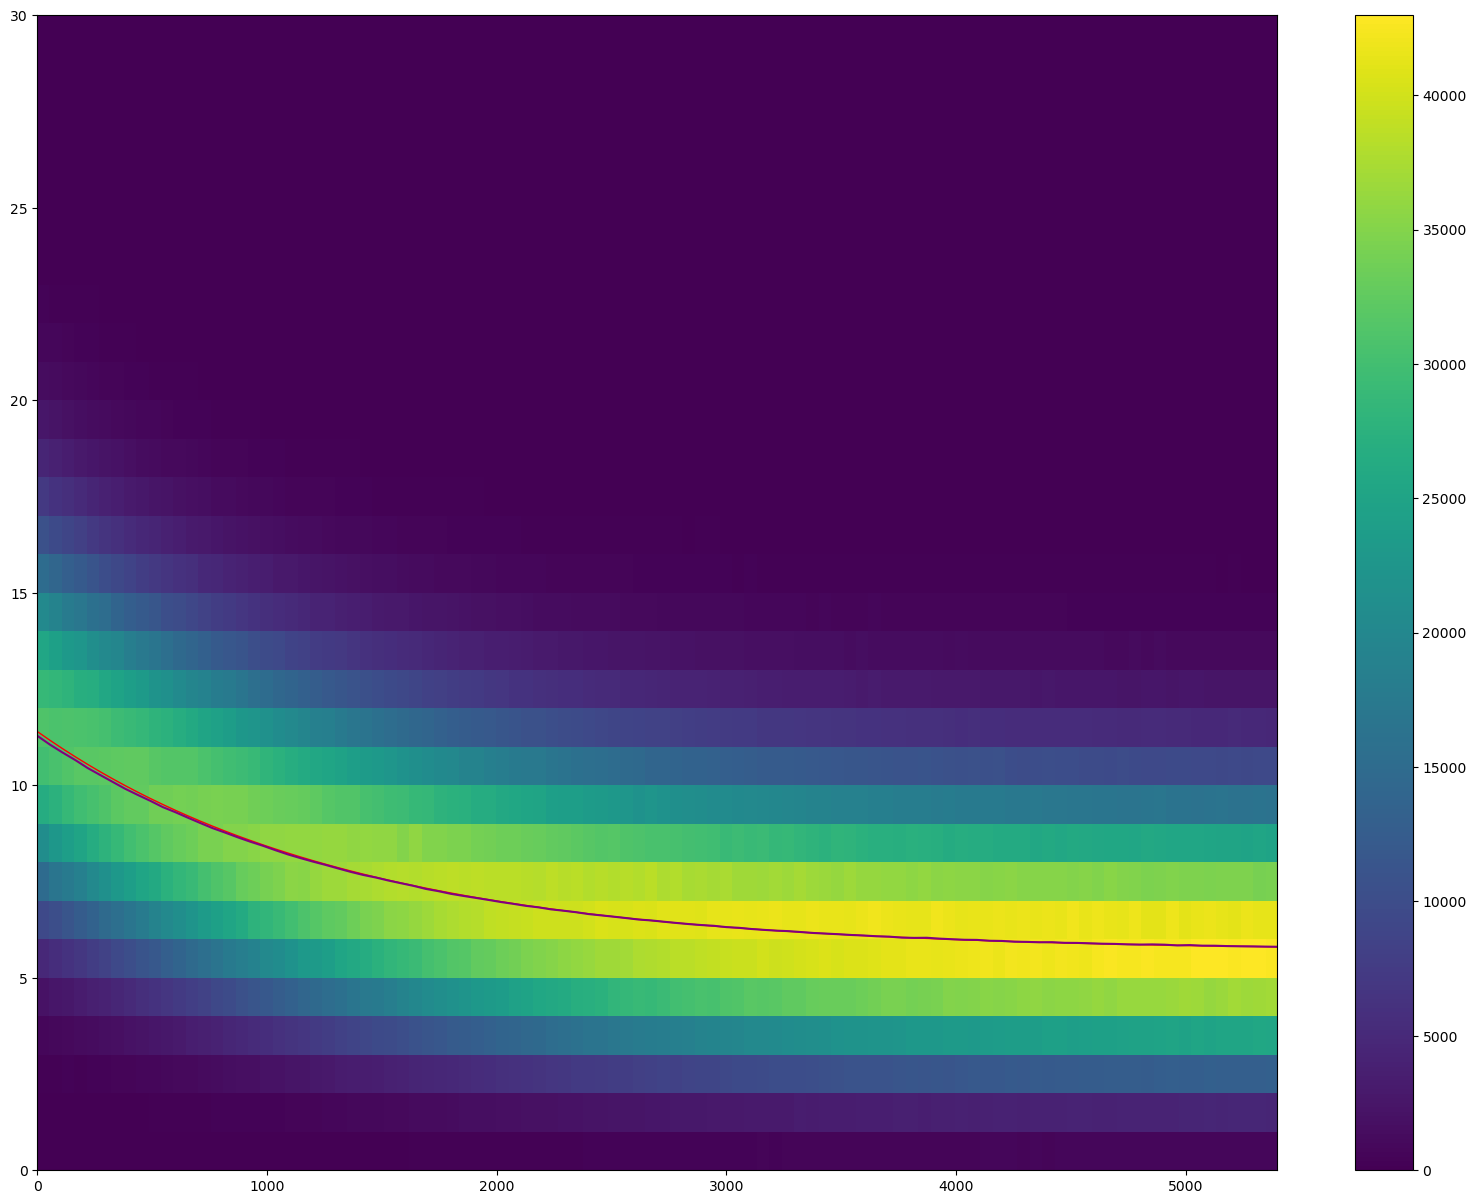

In [48]:

# Define  a new x that corresponds to the time taken to complete an orbit
t = np.linspace(0, 5400, 100)

plt.imshow(H.T, aspect ='auto', origin='lower',
            extent=[t[0], t[-1], yedge[0], yedge[-1]])
plt.plot(t, function(long(t), a, b, c), color = 'r', linewidth = 1)
plt.plot(t, means, color = 'purple')
plt.colorbar(img)

To judge the model of the background, we plot the model poisson distribution over the sample for different longitudes

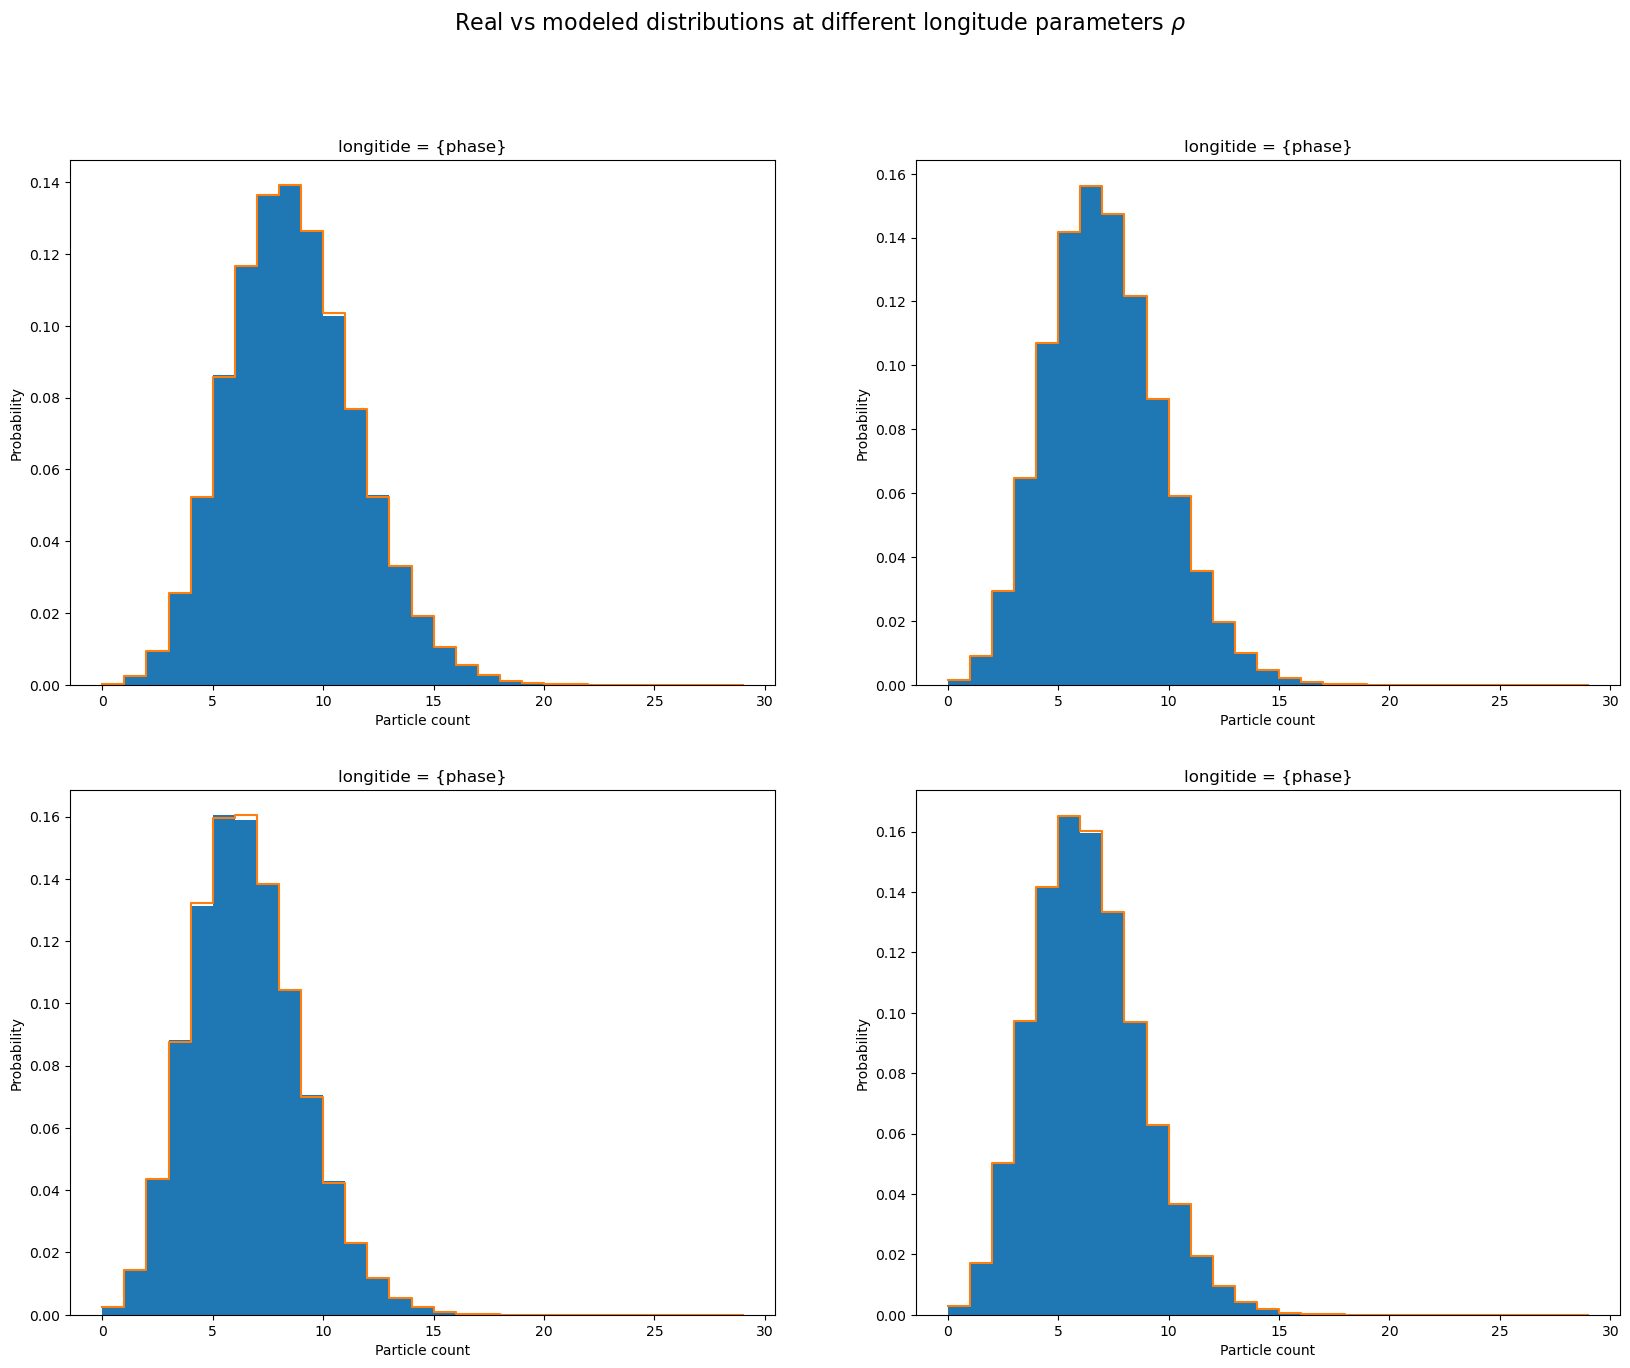

In [49]:
fig, axs = plt.subplots(2,2, figsize = (20,15))

width = 3
phases = [75, 165, 255, 345]
for phase, ax in zip(phases, axs.flatten()):
    window = counts[np.abs(phase - newLong) < 3]
    mean = window.mean()
    x = np.arange(0, 30)
    ax.hist(window, x, density = True, label = "Real Distribution")
    ax.step(x, stats.poisson.pmf(x, mu = function(phase, a, b, c)), where = 'post', label = 'Modeled Distribution')
    
    ax.set_xlabel("Particle count")
    ax.set_ylabel("Probability")
    ax.set_title("longitide = {phase}")

plt.suptitle("Real vs modeled distributions at different longitude parameters $\\rho$", fontsize=16);

The above plots shoes a poisson distribution with a mean given by the time dependent model overlayed onto a histogram with a correponding slice of longitude. As is illustrated by the four plots, the model has very close agreement with the data. 

4) *Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?*

In general the five sigma detection threshold is calculated by finding the corresponding probability on a normal distribution, then using the inverse survival function to find the correponding measurement value. Therefore, since the mean of the distribution changes as a function of time, the mean used to calculate the corresponding measurement value from the inverse survival function will have time dependence. 

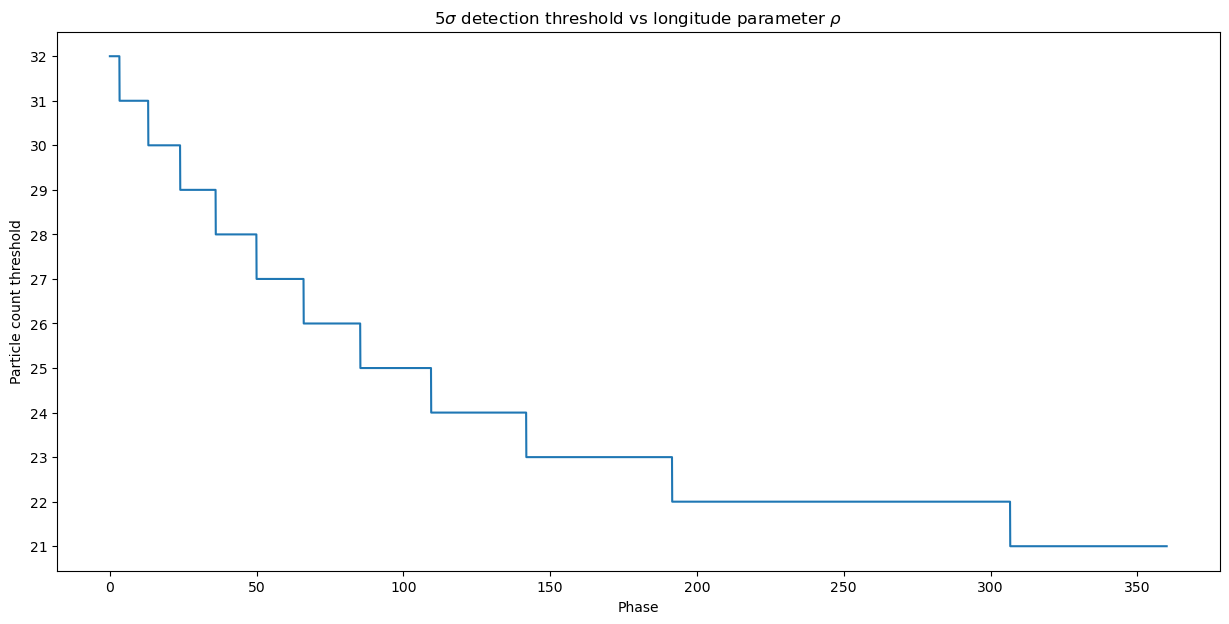

In [21]:
# The probability that corresponds to 5 sigma detections
prob = stats.norm.sf(5)
phase = np.linspace(0,360,5000)
threshold = stats.poisson.isf(prob, mu = function(phase, a, b, c))


fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(phase, threshold)
ax.set_xlabel("Phase")
ax.set_ylabel("Particle count threshold")
ax.set_yticks(np.arange(21,33))
ax.set_title(r"$5\sigma$ detection threshold vs longitude parameter $\rho$");

The above plot shows the 5 sigma counts threshold as a function of phase. In order to find the 5 sigma threshold for a given time, one would perform, time modulo 5400, find the corrsponding phase using longitude = (360/5400)t and compare that longitude to the plot above. 

5) *Optional: Optional: while this is simulated data, it is based on a real effect seen by low Earth orbit satellites. Can you identify the cause of the variable background and propose a physical model?*

The cause of the variable backroung is the irradiation of satellites as they pass over a certain longitude. One possible source of radiation is the innermost Van Allen belt. At a certain point over the earth the shape of the belt comes nearer to earth than in other spots. Therefore it is likley that at longitude = 315 the satellite passes through this low point in the radiation belt and becomes irradiated. The satellite quickly moves out of this region and the radiation decays as it circles the earth until it crosses the radiation belt again and is re-irradiated. 

## Problem 2

In [51]:
# Part 1
images = h5py.File('images.h5', 'r') #Import the file
image1 = images.get('image1') # import the data into an array variable using the get method
imageStack = np.array(images.get('imagestack'))
images.close()

### **2**  
Explore the data: Is there signal contamination? Is the background time dependent? Is it consistent spatially? Develop a plan to calculate the PDF()

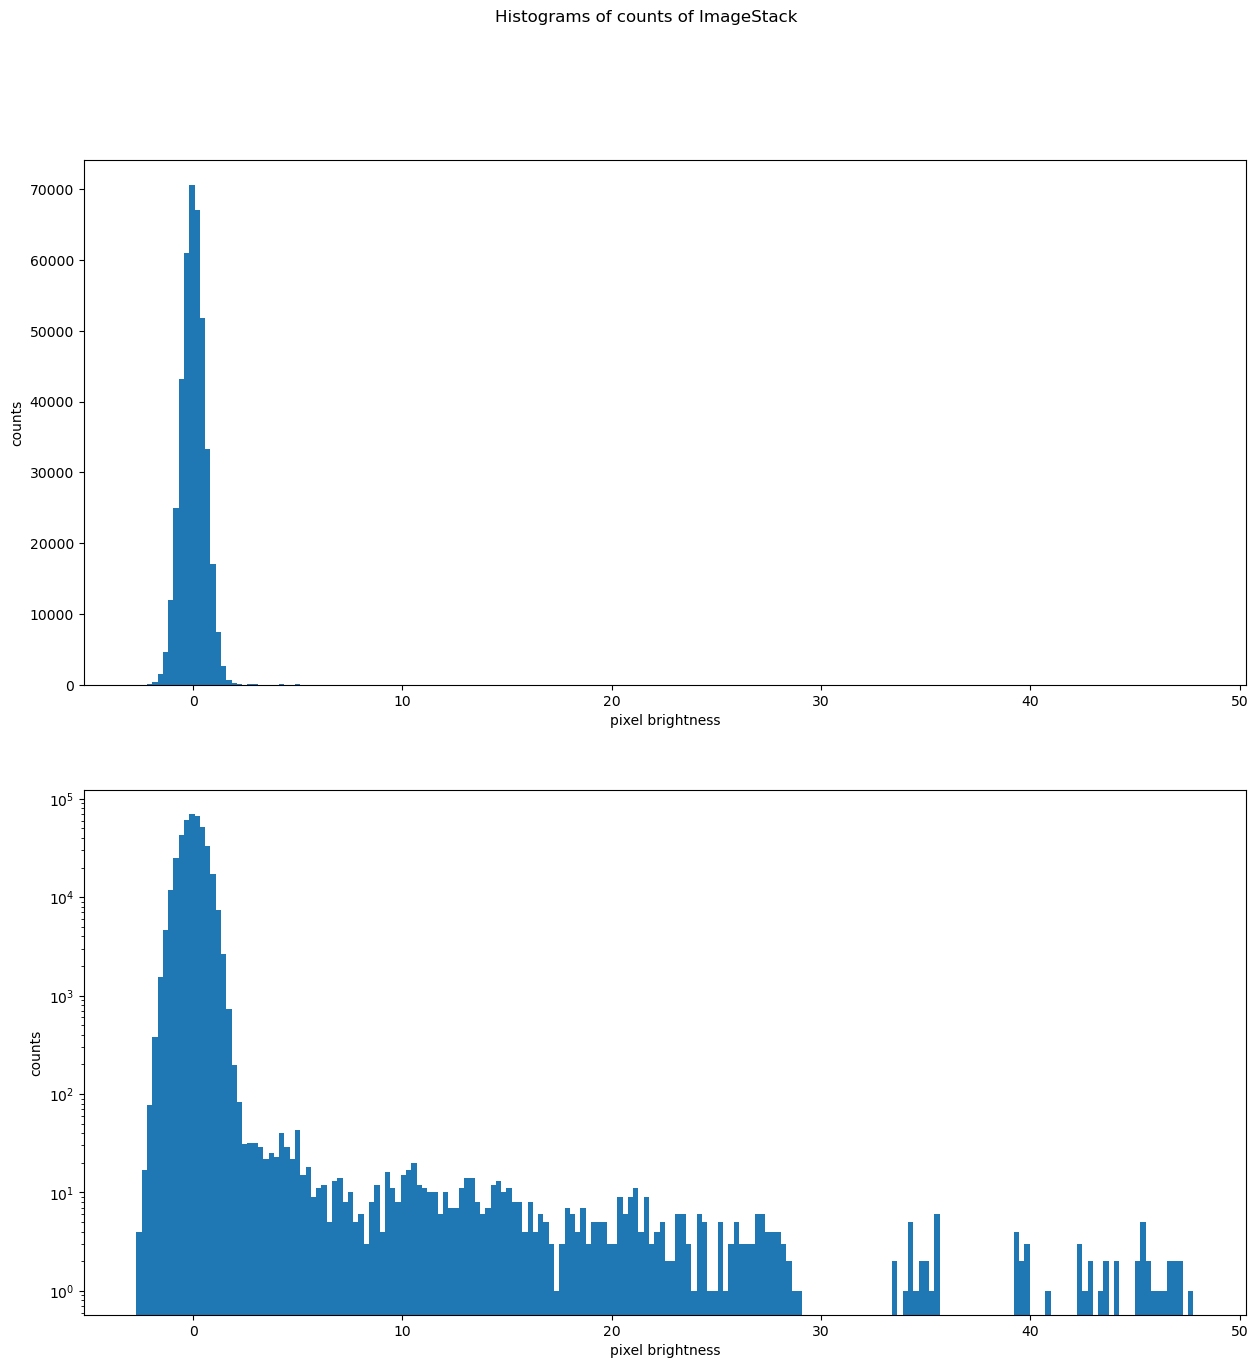

In [55]:
# Search for contamination: Plot the data as a histogram
fig, ax = plt.subplots(2,1, figsize = (15,15))

allData = imageStack.flatten()
ax[1].set_yscale('log')

for a in ax:
    a.hist(allData, 200)
    a.set_ylabel('counts')
    a.set_xlabel('pixel brightness')
fig.suptitle("Histograms of counts of ImageStack");

This histogram makes evident that the signal is contaminated by noise associated with the sky and ccd. This noise is represented by the normal looking distribution centered around coutns = 0 on the left of the histogram

To see if the background is time dependent we gotta plot them at different times

Text(0.5, 0.98, 'Histograms of counts of constituent images')

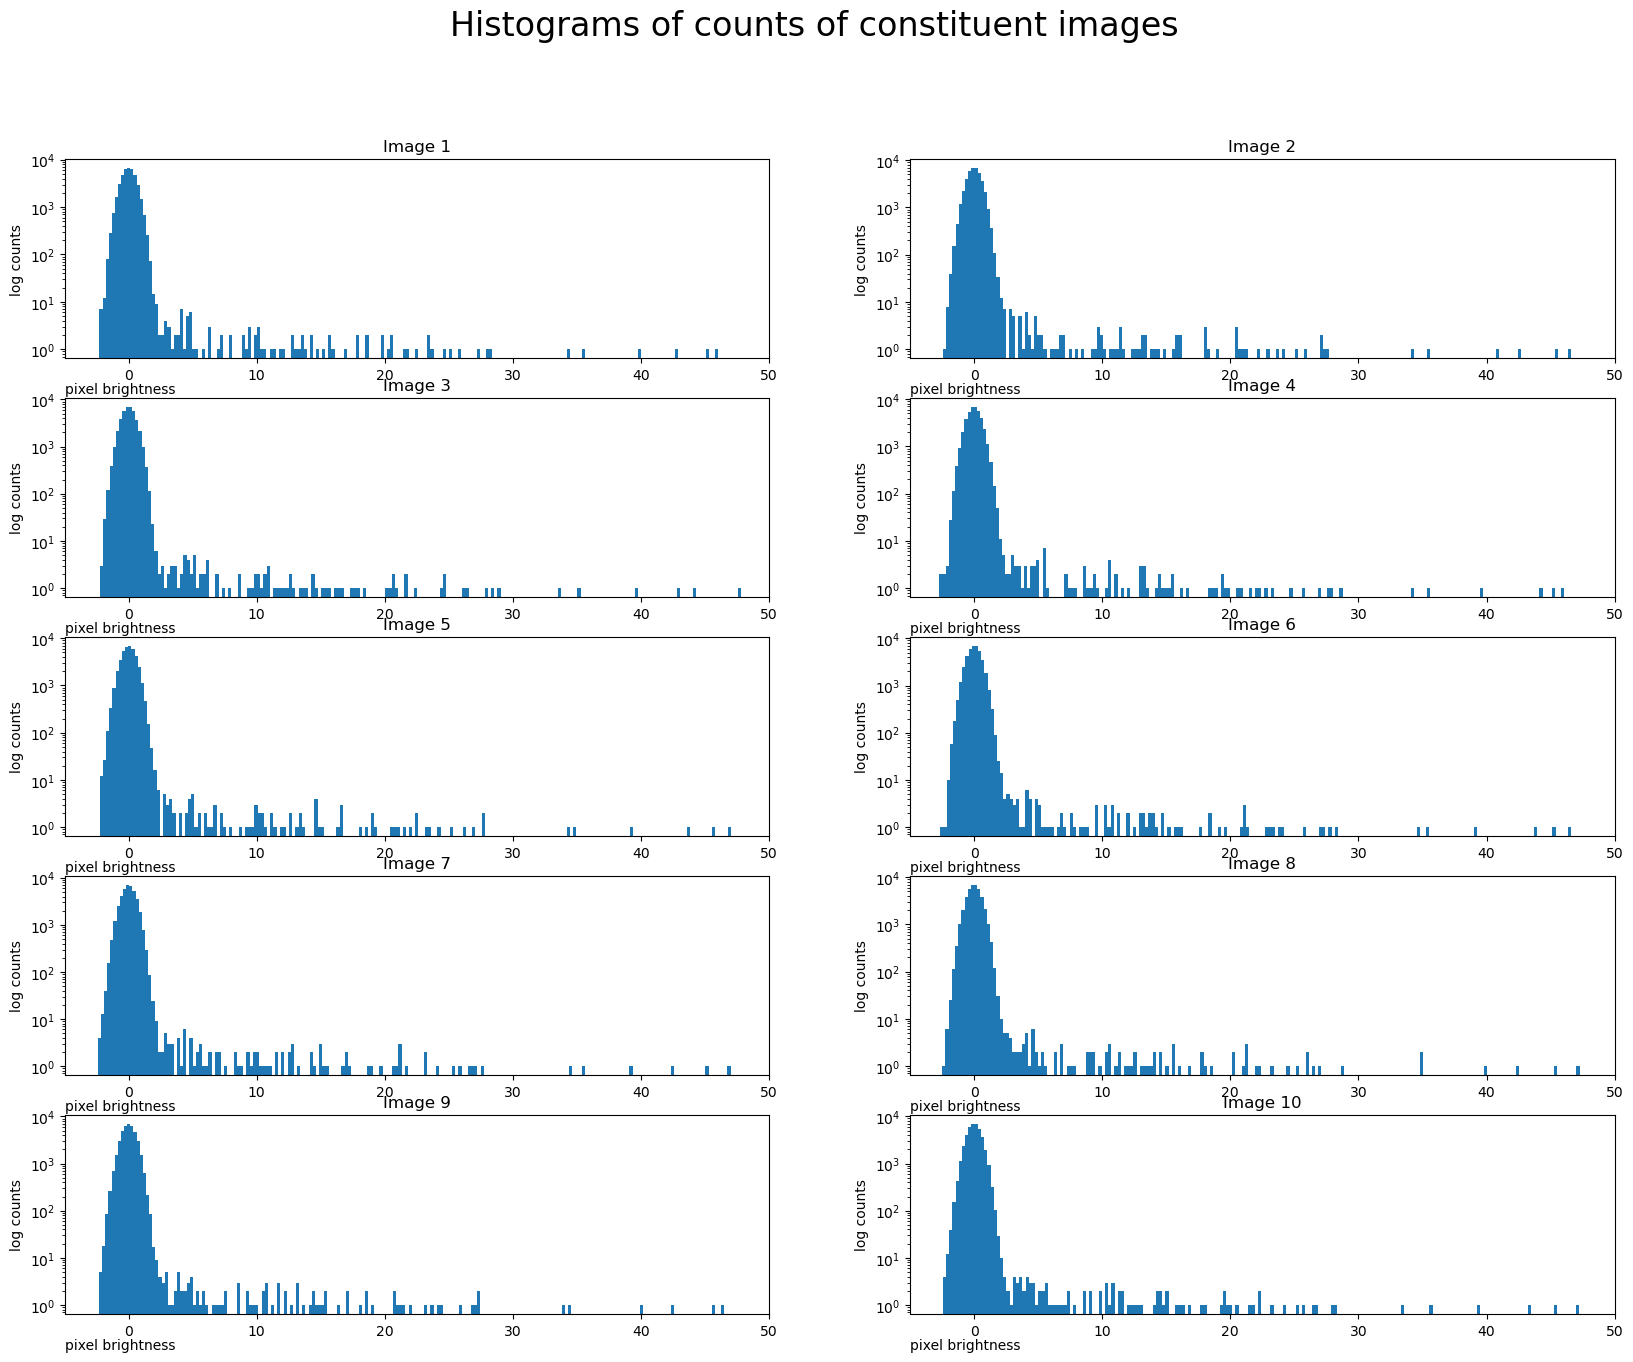

In [58]:
fig, ax = plt.subplots(5, 2, figsize = (20, 15))
pics = np.arange(0,10)

for a, p in zip(ax.flatten(), pics):
    pixels = imageStack[:,:,p].flatten()
    a.hist(pixels, 200)
    a.set_yscale('log')
    a.set_xlim([-5, 50])
    
    a.set_title(f"Image {p+1}")
    a.set_xlabel('pixel brightness', loc = 'left', labelpad = 0.1)
    a.set_ylabel('log counts')
plt.suptitle('Histograms of counts of constituent images', fontsize = 24)

Based on the fact that the background has about the same shape and size across all 10 images, it is ok to assume that the backround is consistent across time. 
To determine whether the background is consistent spacially, I will split the image into 4 different sections and plot histograms of all of the pixels from the stacked image. 

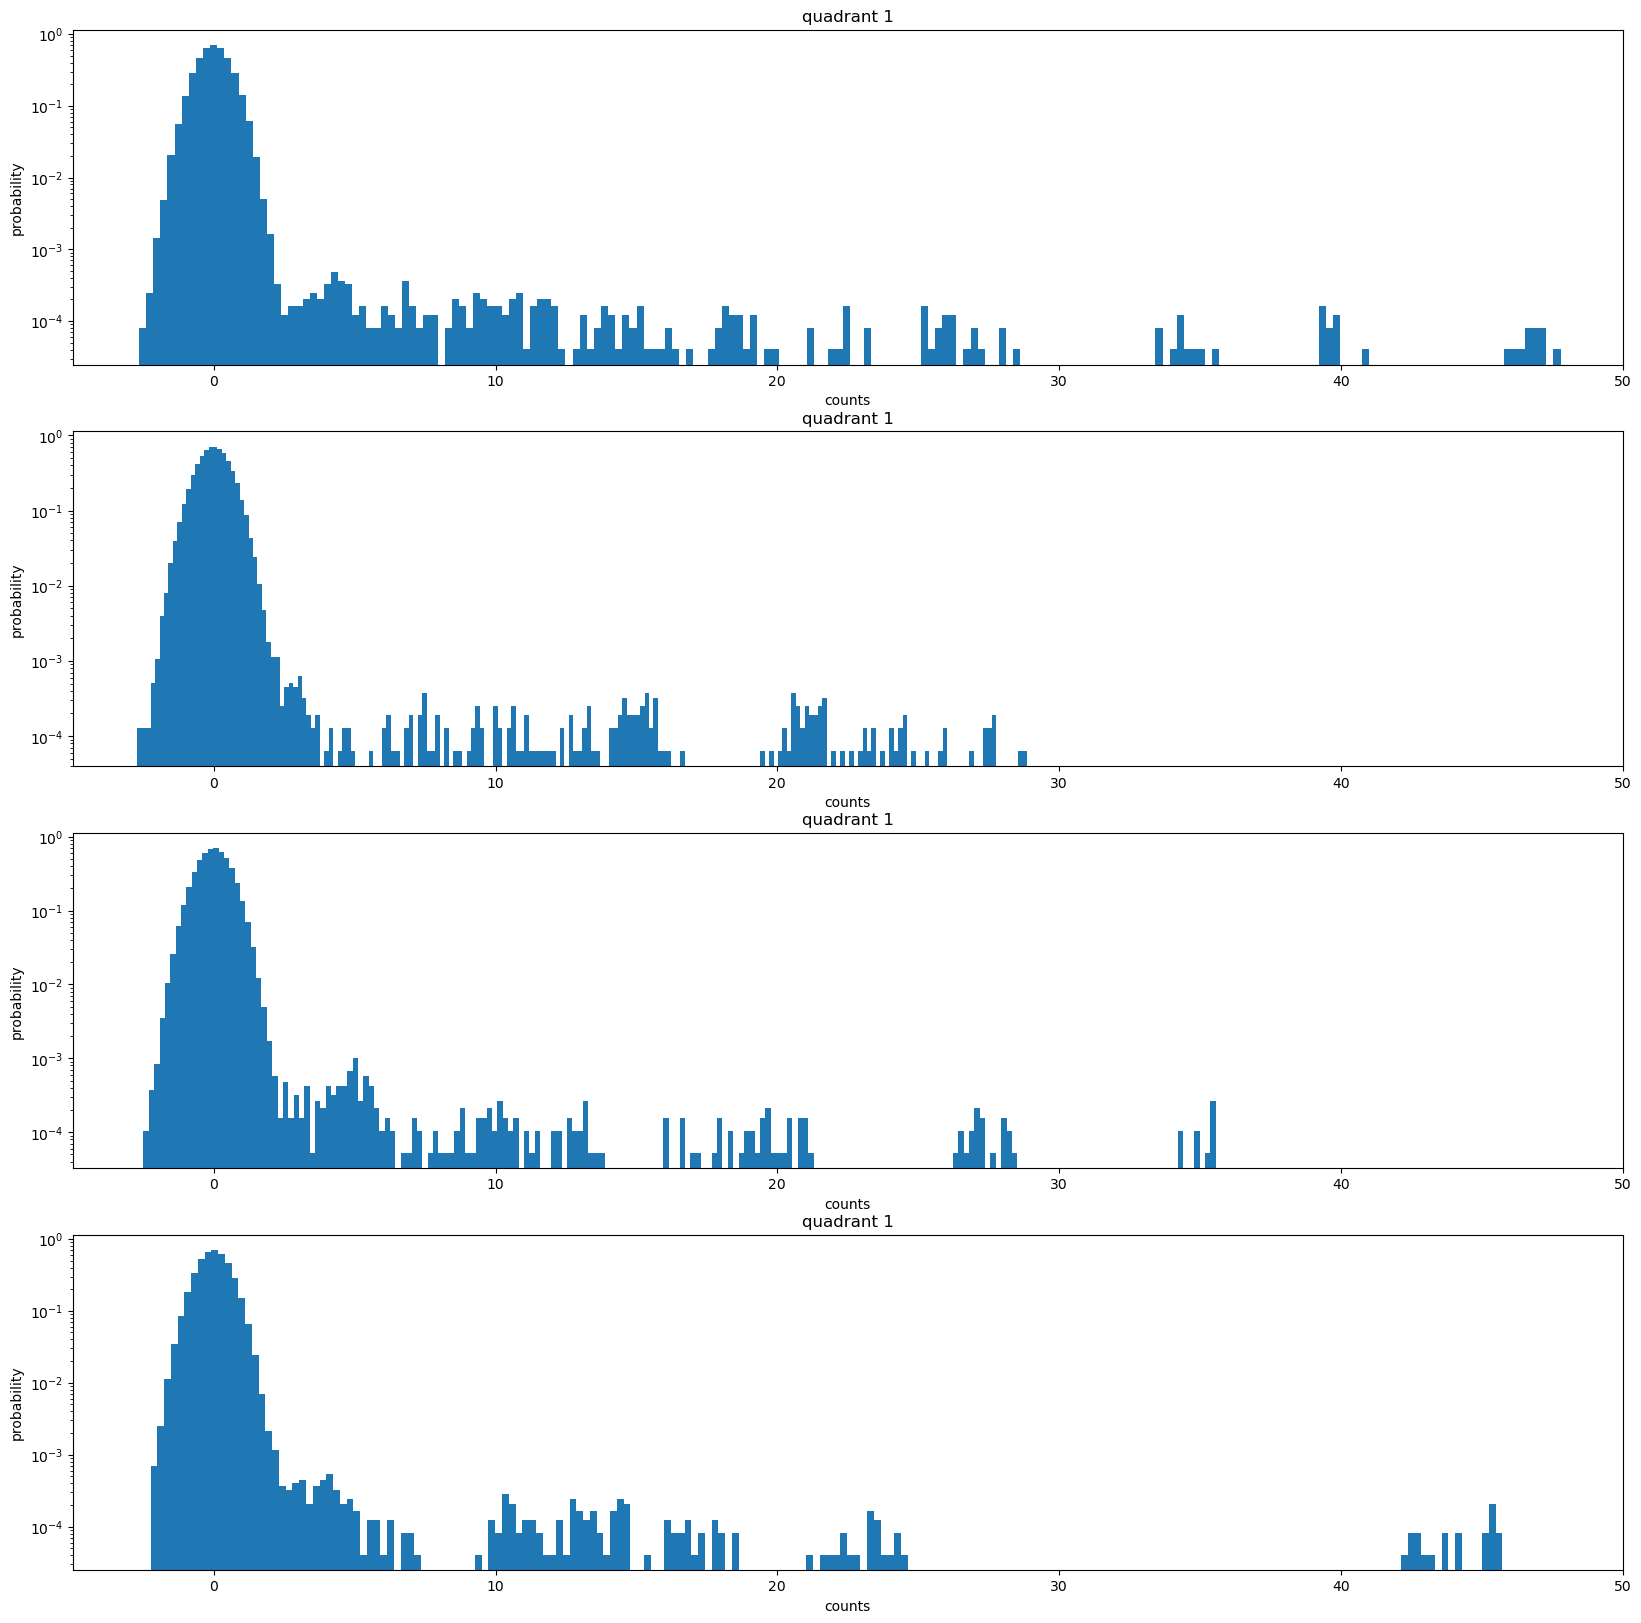

In [59]:


quad1 = imageStack[0:99,0:99,:].flatten()
quad2 = imageStack[99:,0:99,:].flatten()
quad3 = imageStack[0:99,99:,:].flatten()
quad4 = imageStack[99:,99:,:].flatten()

quads = [quad1, quad2, quad3, quad4]

fig, ax = plt.subplots(4,1, figsize = (20,20))

for q, a in zip(quads, ax.flatten()):
    i = 1
    a.hist(q, 200, density = True)
    a.set_title(f'quadrant {i}')
    i += 1
    a.set_yscale('log')
    a.set_xlim([-5,50])
    a.set_xlabel('counts')
    a.set_ylabel('probability')


The background is consistent across the four histograms so it is ok to assume that it is consistent spacially

With the knowledge that the background is consistent across all of the images, I need to identify the faint stars. To do this I need to reduce the amount of noise as much as possible. This corresponds to taking the average of all of the images which will reduce the width of the noise histogram and should allow me to asses the significance of the faint stars using a skinnier background than that in any of the original images.

First I need to calculate the background. To calculate the backgound, I would like to subtract two of the unstacked images from each other, and then fit a gaussian distribution to the remaining pixels. 

mu = 0.007820703547894147, sigma = 0.7920123682439


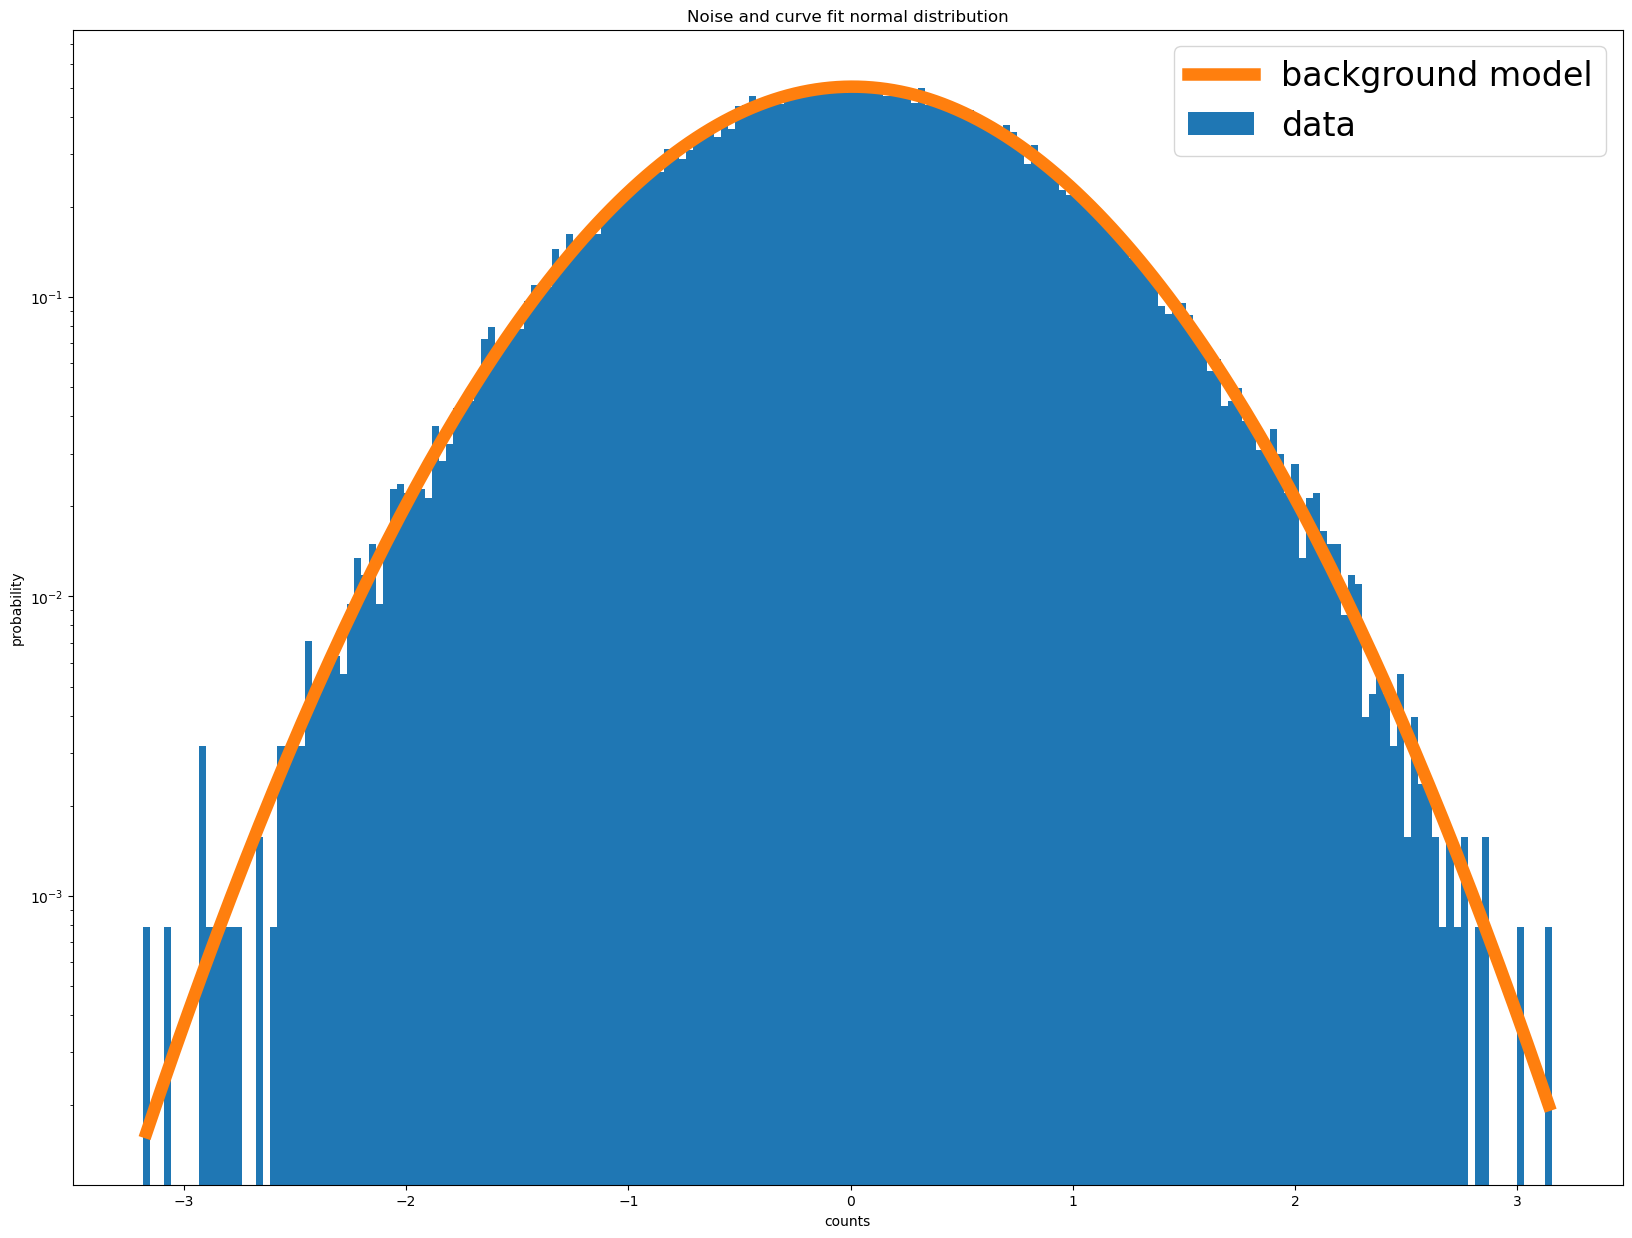

In [79]:
# Subtract the stars from the image
diffImage = imageStack[:,:,2].flatten() - imageStack[:,:,8].flatten();

fig, ax = plt.subplots(1,1, figsize = (20,15))

def gaussian(x, mu, sigma):
    return stats.norm.pdf(x, loc = mu, scale = sigma)

heights, bins, _ = ax.hist(diffImage, 200, density = True, label = 'data');
ax.set_yscale('log')

binCenters = bins[:-1] + (bins[1] - bins[0])/2


[mu, sigma], _ = scipy.optimize.curve_fit(gaussian, binCenters, heights)
print("mu = {}, sigma = {}".format(mu,sigma))
ax.plot(binCenters, stats.norm.pdf(binCenters, loc = mu, scale = sigma), linewidth = 9, 
        label = 'background model')
ax.set_xlabel('counts')
ax.set_title('Noise and curve fit normal distribution')
ax.set_ylabel('probability')
ax.legend(fontsize = 24)

The above plot shows only the noise of the image. Since the stars are constant, they were subtracted out when the difference of the two images was calculated. What remained was only the noise associated with the images. As a result of calculating the difference, sigma of the original noise distribution was mutliplied by a factor of $\sqrt{2}$. 

(1e-06, 1)

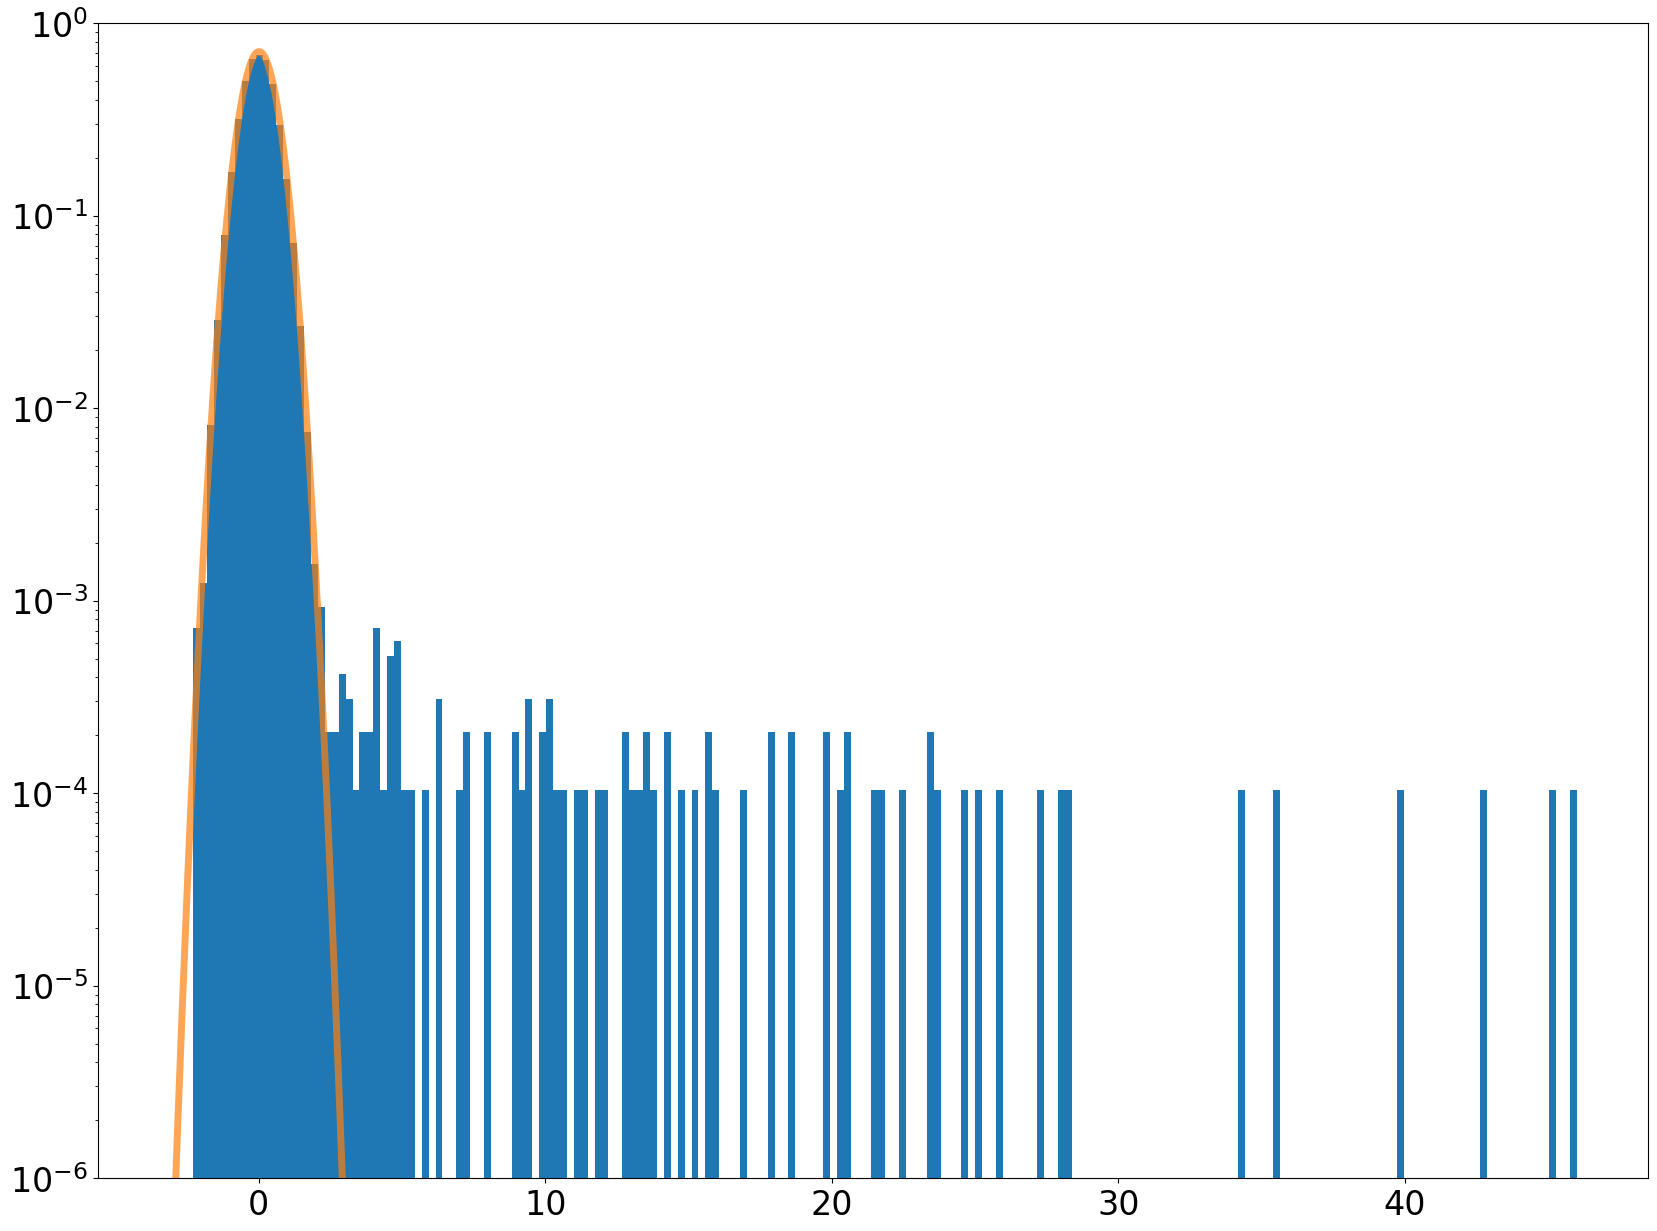

In [80]:
#Correct sigma
sigma = sigma/np.sqrt(2)

fig, ax = plt.subplots(1,1, figsize = (20,15))
plt.tick_params(labelsize = 24)
ax.hist(imageStack[:,:,0].flatten(), 200, density = True)
ax.plot(binCenters, stats.norm.pdf(binCenters, loc = mu, 
                                   scale = sigma),
        linewidth = 5, alpha = 0.7)
ax.set_yscale('log')
ax.set_ylim([10e-7, 1])


Now I will average all of images together in order to confine the width of the background by a factor of $ 1 / \sqrt{N} $ where N is the number of images averaged.

0.1770993494413956


Text(0, 0.5, 'probability')

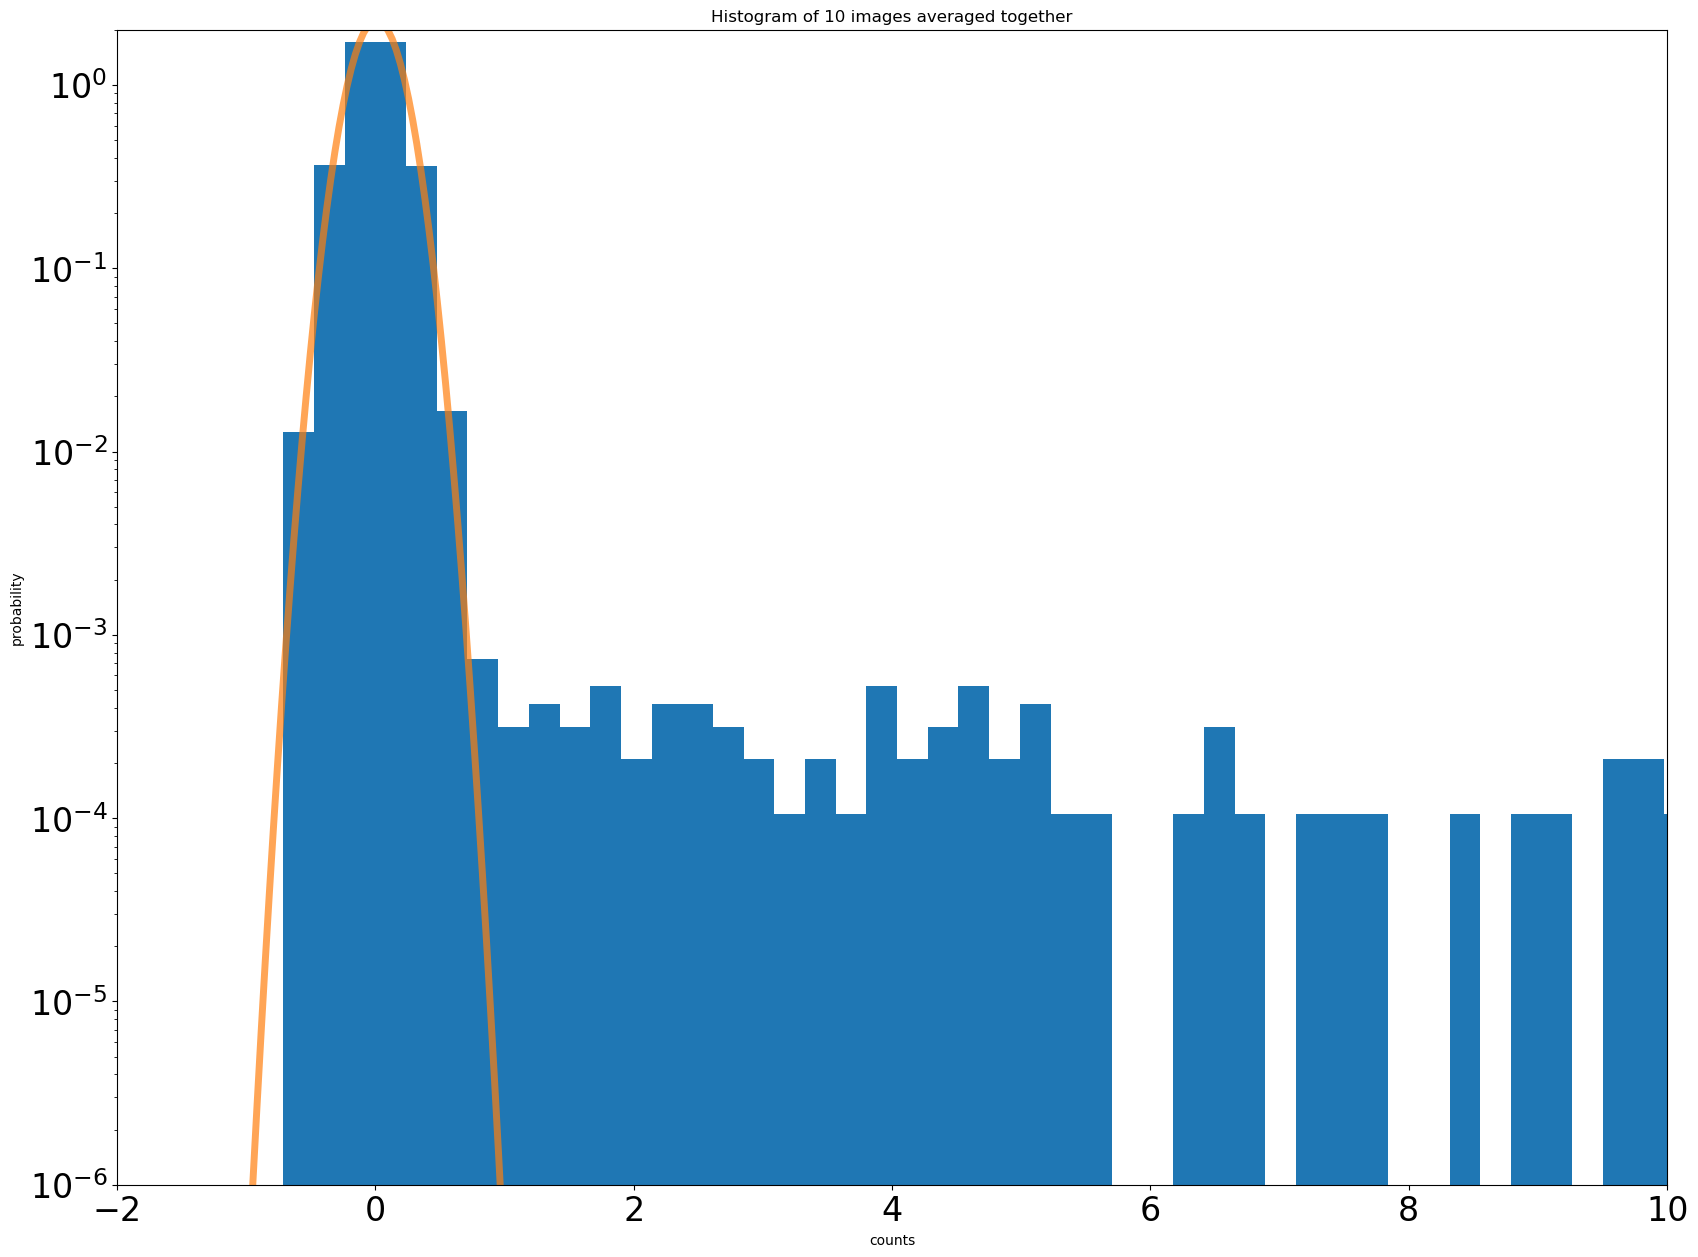

In [81]:
averageImage = np.mean(imageStack[:,:,:], axis = 2)

fig, ax = plt.subplots(1,1, figsize = (20,15))
plt.tick_params(labelsize = 24)

ax.hist(averageImage.flatten(), 200, density = True)
ax.plot(binCenters, stats.norm.pdf(binCenters, loc = mu, 
                                   scale = sigma/np.sqrt(10)), #Multiply this by the above factor in order to verify that the above fit works for when the 
        linewidth = 5, alpha = 0.7)
ax.set_yscale('log')
ax.set_ylim([10e-7, 2])
ax.set_xlim([-2, 10])
ax.hist
print(sigma/np.sqrt(10))
ax.set_title("Histogram of 10 images averaged together")
ax.set_xlabel('counts')
ax.set_ylabel('probability')

The figure above is the histogram of the 10 images averaged together. The gaussian distribution that is overlayed is the fit for the background generated above with sigma scaled by $ 1 / \sqrt{10} $ since the average was taken for 10 images. To identify the faint stars, the number of counts that corresponds to a 5 sigma detection is calculated and all of the pixels with counts greater than that threshold are identified as stars.

The counts required to be a star for sigma = 5 is 0.8353432830436408
The number of stars detected above 5 sigma is 128


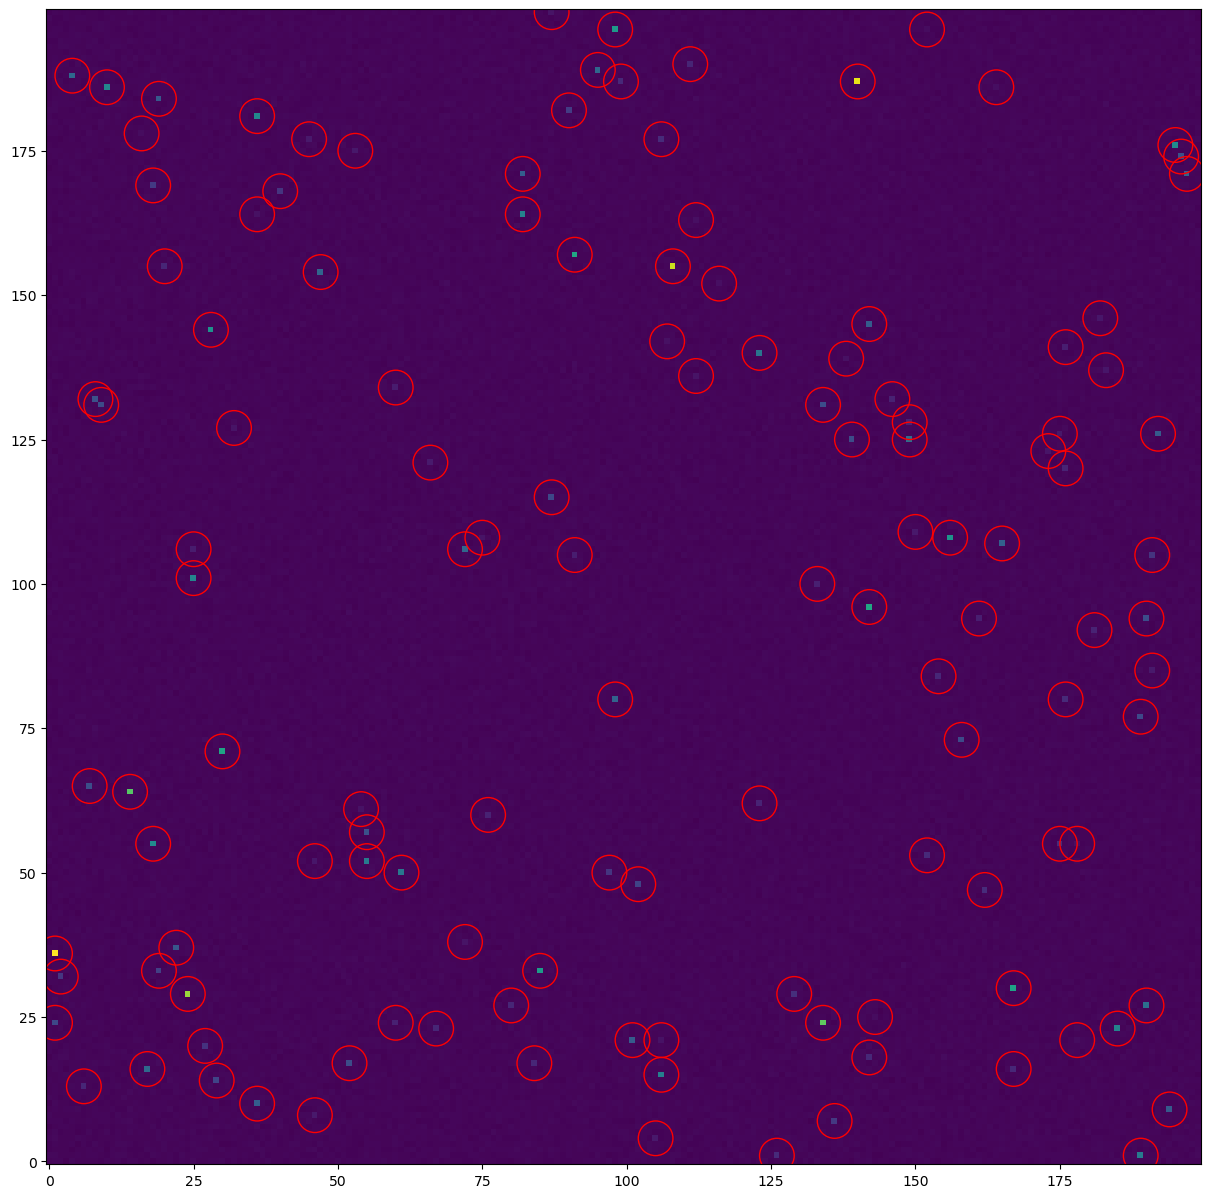

In [82]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
threshold = 5

counts = stats.norm.isf(stats.norm.pdf(threshold), loc = mu, scale = sigma/np.sqrt(10))
print(f'The counts required to be a star for sigma = 5 is {counts}')


stars =  averageImage > counts
ax.imshow(averageImage, origin = 'lower')

number = 0
y, x = np.where(stars == True)
for i, j in zip(x, y): 
    number += 1
    xy =  (i,j)
    ax.add_patch(plt.Circle(xy, radius = 3, linewidth = 1, color = 'r', fill = False))

print(f"The number of stars detected above {threshold} sigma is {number}")

#### 4)
I was working on finding faint stars while my lab partner was working on finding transient stars. Locating faint stars required that noise distribution be as skinny as possible so that the measurement threshold for detection corresponding to 5 sigma was as low as possible. By averageing the images together the width of the distribution corresponding to the noise was made skinnier while the signals that correspond to stars remained where they were. This enabled the detection of stars that were before washed out by the noise distribution. 

My partner was looking for transient stars which are events that are very bright and only occur in a single image. The PDF of the noise used for both analysis' was the same however, to calculate the significance of detection, his PDF was multiplied by a trials factor in order to account for the fact that his detection corresponded to a detection after searching through 10 images. 